In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from construct import *
import scipy.signal

import ccsds
import tianwen1_tm

import struct
import collections

In [2]:
def get_packet(p):
    return p[0] if type(p) is tuple else p

def packets_asarray(packets):
    return np.array([np.frombuffer(get_packet(p)[ccsds.SpacePacketPrimaryHeader.sizeof():], 'uint8')
                     for p in packets])

def plot_apids(apids, sc, vc):
    for apid in sorted(apids.keys()):
        plt.figure(figsize = (16,16), facecolor = 'w')
        ps = packets_asarray(apids[apid])
        plt.imshow(ps, aspect = ps.shape[1]/ps.shape[0])
        plt.title(f'APID {apid} Spacecraft {sc} Virtual channel {vc}')
        
def get_timestamps(aos):
    return np.array([tianwen1_tm.parse_timestamp_datetime64(a.insert_zone.timestamp) for a in aos])

def get_packet_timestamps(packets):
    return np.array([tianwen1_tm.parse_timestamp_datetime64(p[1]) for p in packets])

In [3]:
frame_size = 220
frames = np.fromfile('tianwen1_frames_20200730.u8', dtype = 'uint8')
frames = frames[:frames.size//frame_size*frame_size].reshape((-1, frame_size))
frames.shape[0]

111954

### AOS headers

In [4]:
aos = [ccsds.AOSFrame.parse(f) for f in frames]

In [5]:
collections.Counter([a.primary_header.transfer_frame_version_number for a in aos])

Counter({1: 111790, 0: 9, 2: 147, 3: 8})

In [6]:
collections.Counter([a.primary_header.spacecraft_id for a in aos])

Counter({245: 83834,
         82: 27944,
         98: 2,
         19: 1,
         58: 137,
         182: 1,
         241: 1,
         20: 1,
         210: 1,
         5: 2,
         255: 2,
         234: 2,
         194: 1,
         43: 1,
         97: 1,
         219: 1,
         155: 1,
         66: 1,
         180: 1,
         230: 3,
         153: 1,
         48: 1,
         204: 1,
         83: 1,
         111: 1,
         217: 1,
         161: 1,
         133: 1,
         166: 1,
         169: 1,
         239: 1,
         23: 1,
         17: 1,
         224: 1,
         79: 1,
         242: 1})

In [7]:
collections.Counter([a.primary_header.virtual_channel_id for a in aos
                     if a.primary_header.spacecraft_id == 245])

Counter({1: 55885, 3: 27943, 2: 6})

In [8]:
collections.Counter([a.primary_header.virtual_channel_id for a in aos
                     if a.primary_header.spacecraft_id == 82])

Counter({1: 27944})

In [9]:
[(a.primary_header.spacecraft_id, a.primary_header.virtual_channel_id) for a in aos[:20]]

[(245, 1),
 (245, 1),
 (245, 3),
 (82, 1),
 (245, 1),
 (245, 1),
 (245, 3),
 (82, 1),
 (245, 1),
 (245, 1),
 (245, 3),
 (82, 1),
 (245, 1),
 (245, 1),
 (245, 3),
 (82, 1),
 (245, 1),
 (245, 1),
 (245, 3),
 (82, 1)]

### Spacecraft 82 Virtual channel 1

In [10]:
[a.primary_header for a in aos if a.primary_header.spacecraft_id == 82][:10]

[Container(transfer_frame_version_number=1, spacecraft_id=82, virtual_channel_id=1, virtual_channel_frame_count=705644, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=82, virtual_channel_id=1, virtual_channel_frame_count=705645, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=82, virtual_channel_id=1, virtual_channel_frame_count=705646, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=82, virtual_channel_id=1, virtual_channel_frame_count=705647, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=82, virtual_channel_id=1, virtual_channel_frame_count=705648, replay_flag=False, vc_frame_count_usage_

In [11]:
sc82_vc1 = [a for a in aos if a.primary_header.spacecraft_id == 82 and a.primary_header.virtual_channel_id == 1]
fc = np.array([a.primary_header.virtual_channel_frame_count for a in sc82_vc1])

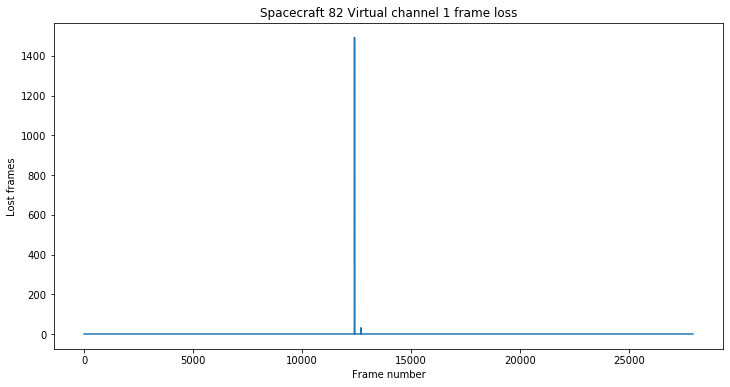

In [12]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(np.diff(fc) - 1)
plt.title('Spacecraft 82 Virtual channel 1 frame loss')
plt.ylabel('Lost frames')
plt.xlabel('Frame number');

In [13]:
[hex(a.insert_zone.timestamp) for a in sc82_vc1][:10]

['0x3021af79d08',
 '0x4021bf79d08',
 '0x3021cf79d08',
 '0x3021df79d08',
 '0x3021ef79d08',
 '0x3021ff79d08',
 '0x30220f79d08',
 '0x30221f79d08',
 '0x30222f79d08',
 '0x40223f79d08']

In [14]:
{hex(a.insert_zone.unknown) for a in sc82_vc1}

{'0x4011'}

In [15]:
sc82_vc1_packets = list(ccsds.extract_space_packets(sc82_vc1, 82, 1))

/home/daniel/jupyter_notebooks/Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 82 VC 1] Broken stream. Last frame count 718055, current frame count 719549
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/jupyter_notebooks/Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 82 VC 1] Broken stream. Last frame count 719549, current frame count 719551
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/jupyter_notebooks/Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 82 VC 1] Broken stream. Last frame count 719551, current frame count 719553
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, cu

In [16]:
sc82_vc1_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p) for p in sc82_vc1_packets]

In [17]:
sc82_vc1_apids = collections.Counter([p.APID for p in sc82_vc1_sp_headers])
sc82_vc1_apids

Counter({1: 27944,
         2: 27944,
         136: 22162,
         129: 25049,
         130: 25054,
         131: 5781,
         5: 2889})

In [18]:
sc82_vc1_by_apid = {apid : [p for h,p in zip(sc82_vc1_sp_headers, sc82_vc1_packets)
                           if h.APID == apid] for apid in sc82_vc1_apids}

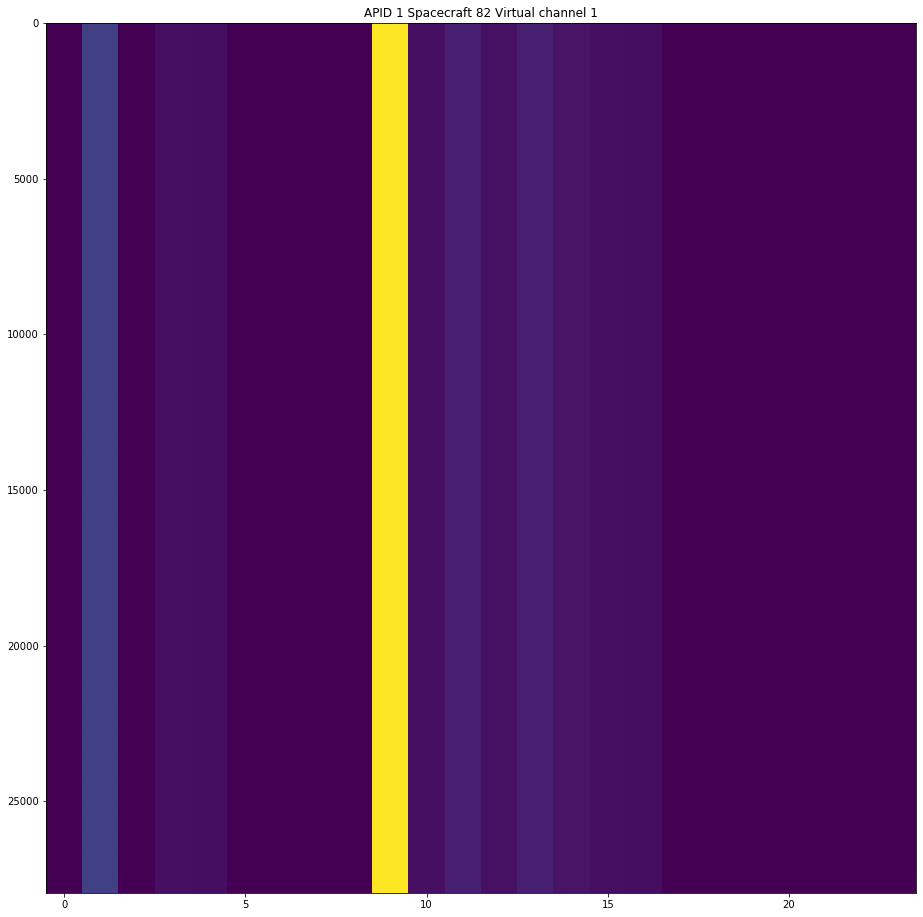

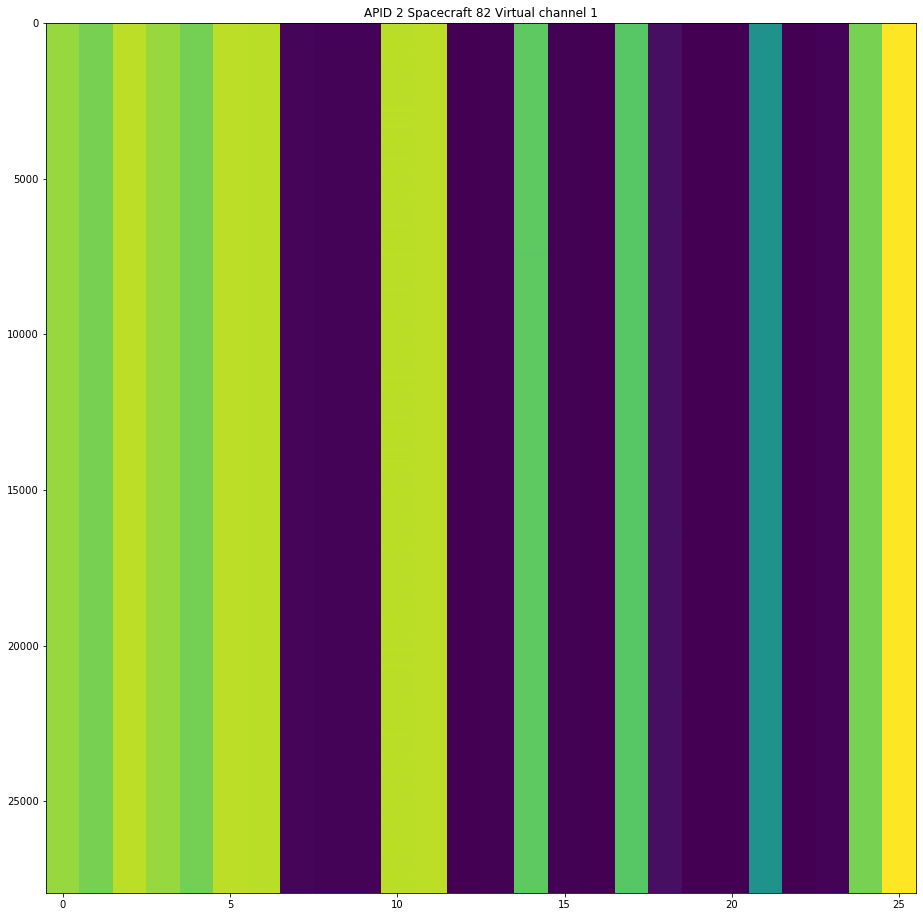

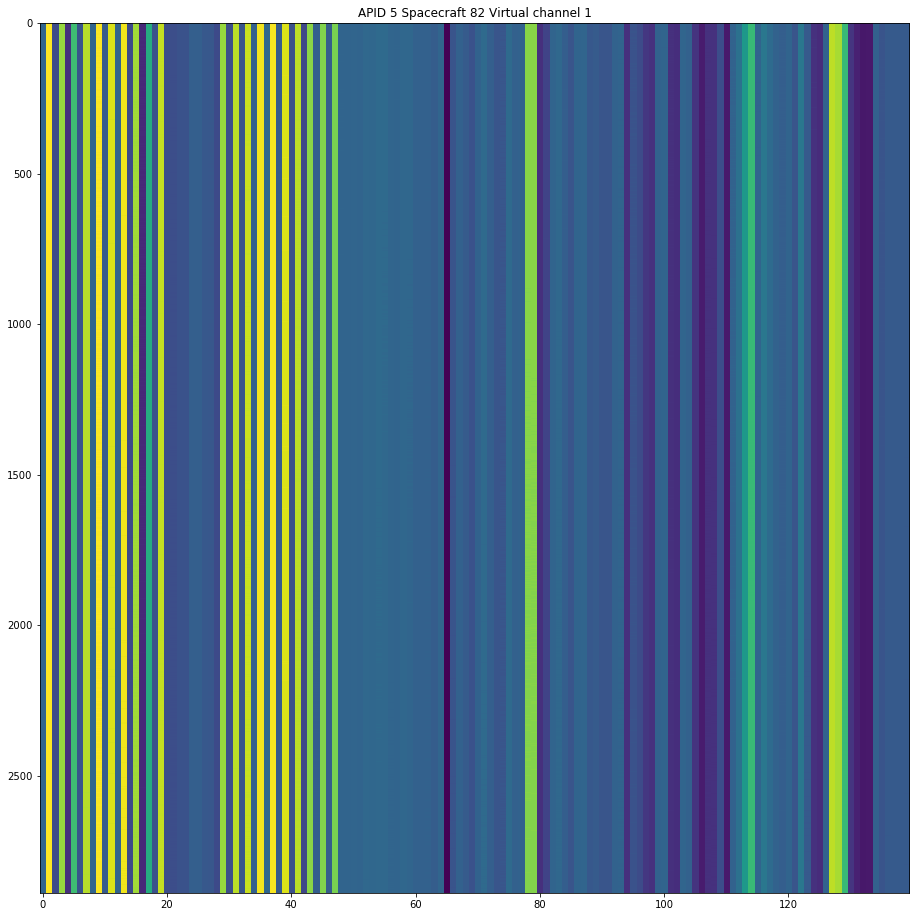

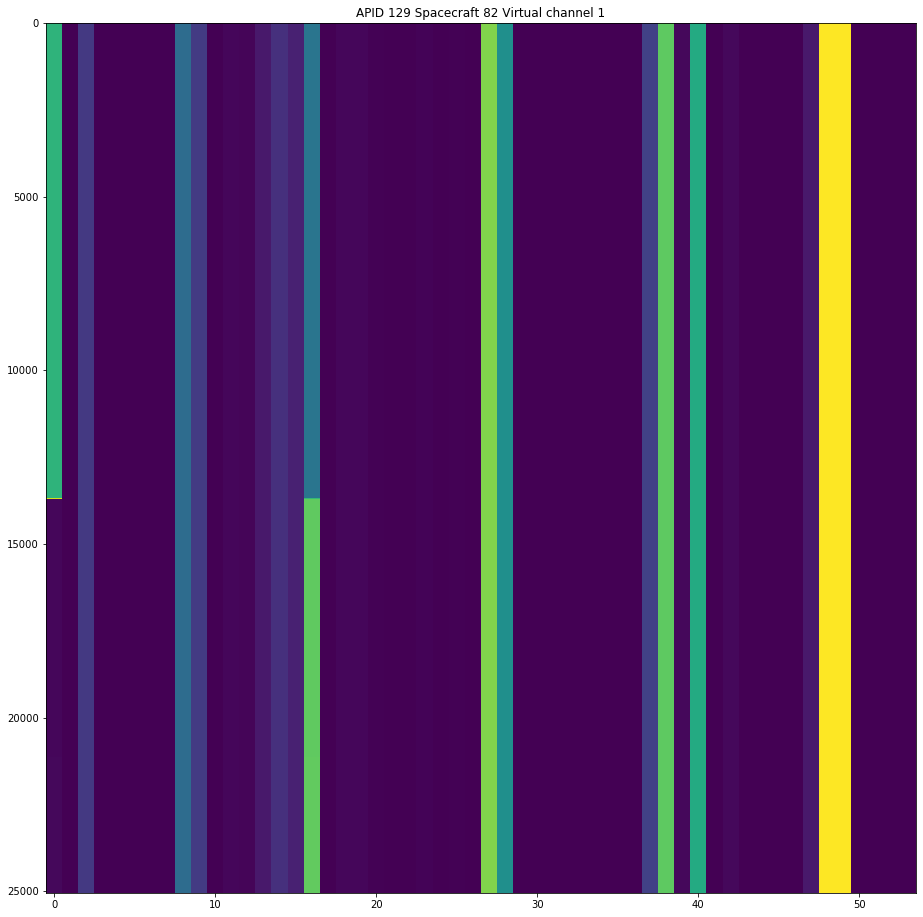

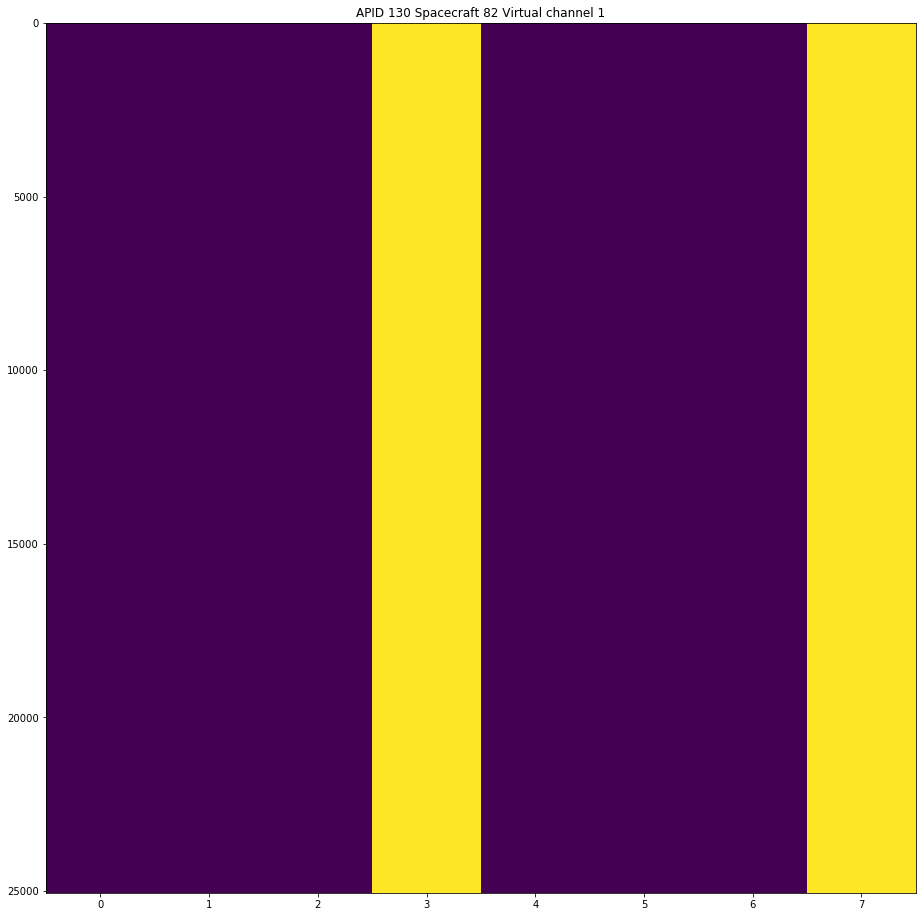

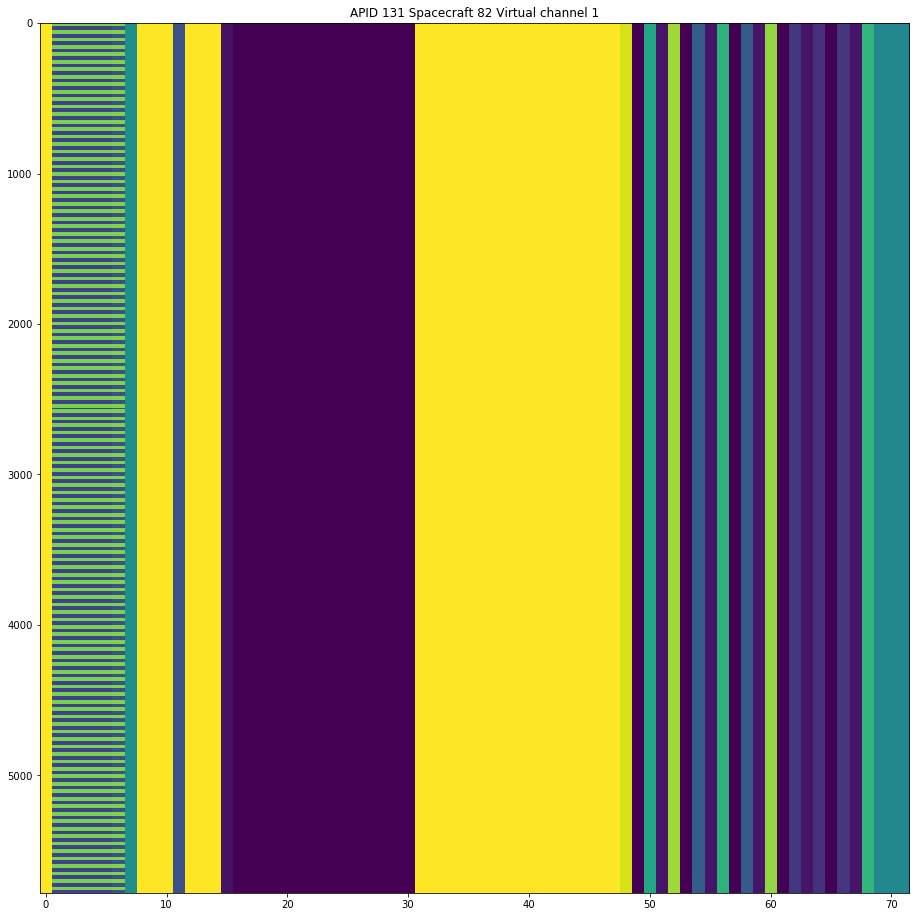

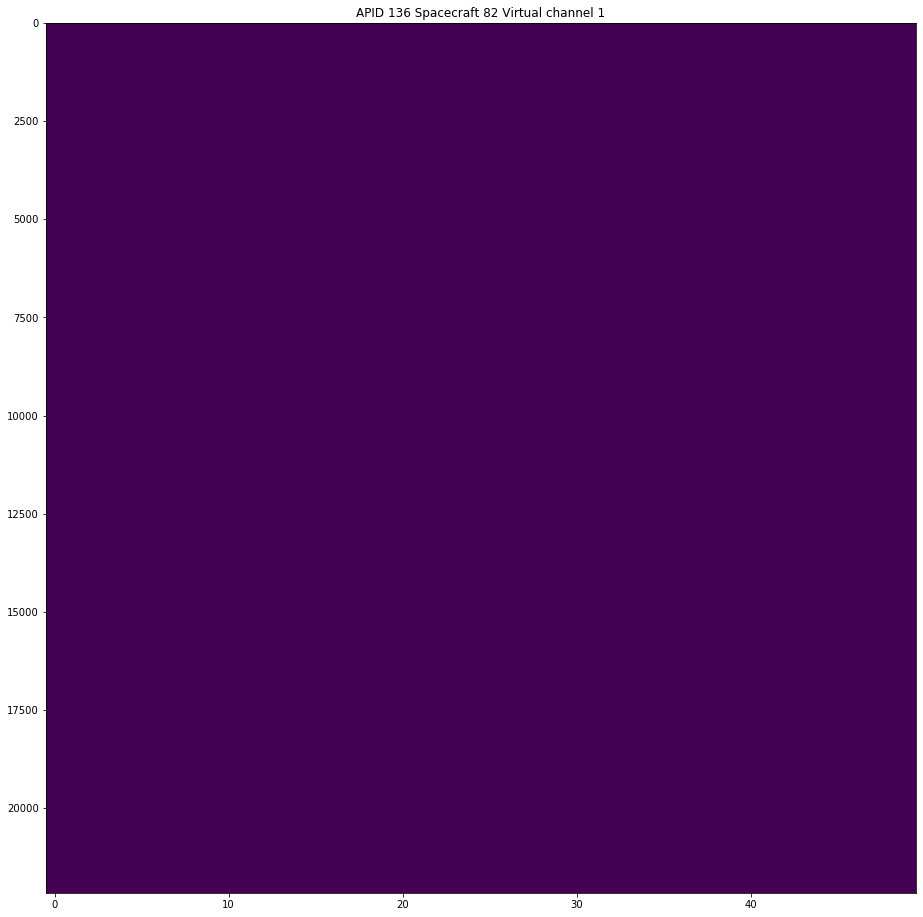

In [19]:
plot_apids(sc82_vc1_by_apid, 82, 1)

### Spacecraft 245 Virtual channel 3

In [20]:
sc245_vc3 = [a for a in aos if a.primary_header.spacecraft_id == 245 and a.primary_header.virtual_channel_id == 3]
fc = np.array([a.primary_header.virtual_channel_frame_count for a in sc245_vc3])

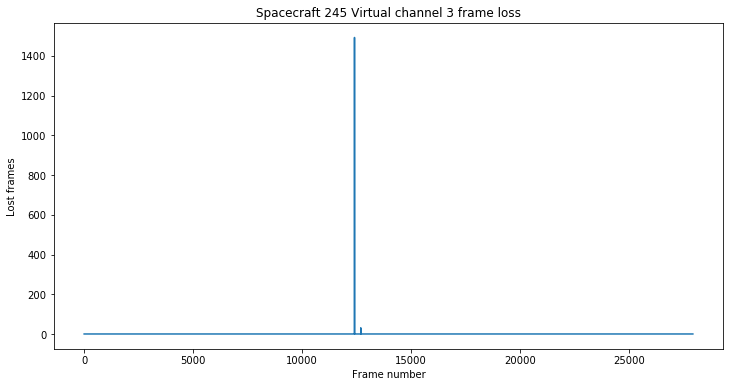

In [21]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(np.diff(fc) - 1)
plt.title('Spacecraft 245 Virtual channel 3 frame loss')
plt.ylabel('Lost frames')
plt.xlabel('Frame number');

In [22]:
[a.primary_header for a in sc245_vc3[:10]]

[Container(transfer_frame_version_number=1, spacecraft_id=245, virtual_channel_id=3, virtual_channel_frame_count=77132, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=2, vc_framecount_cycle=10),
 Container(transfer_frame_version_number=1, spacecraft_id=245, virtual_channel_id=3, virtual_channel_frame_count=77133, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=2, vc_framecount_cycle=10),
 Container(transfer_frame_version_number=1, spacecraft_id=245, virtual_channel_id=3, virtual_channel_frame_count=77134, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=2, vc_framecount_cycle=10),
 Container(transfer_frame_version_number=1, spacecraft_id=245, virtual_channel_id=3, virtual_channel_frame_count=77135, replay_flag=True, vc_frame_count_usage_flag=False, rsvd_spare=2, vc_framecount_cycle=10),
 Container(transfer_frame_version_number=1, spacecraft_id=245, virtual_channel_id=3, virtual_channel_frame_count=77136, replay_flag=True, vc_frame_count_usage_f

In [23]:
sc245_vc3_frames = np.array([f for f,a in zip(frames, aos) if
                            a.primary_header.spacecraft_id == 245 and a.primary_header.virtual_channel_id == 3])

In [24]:
np.unique(sc245_vc3_frames[:,5:12])

array([170], dtype=uint8)

In [25]:
hex(170)

'0xaa'

In [26]:
np.unique(sc245_vc3_frames[:,12])

array([138], dtype=uint8)

In [27]:
hex(138)

'0x8a'

In [28]:
np.unique(sc245_vc3_frames[:,13:])

array([170], dtype=uint8)

In [29]:
hex(sc245_vc3[0].insert_zone.unknown)

'0x8aaa'

### Spacecraft 245 Virtual channel 1

In [30]:
sc245_vc1 = [a for a in aos if a.primary_header.spacecraft_id == 245 and a.primary_header.virtual_channel_id == 1]
fc = np.array([a.primary_header.virtual_channel_frame_count for a in sc245_vc1])

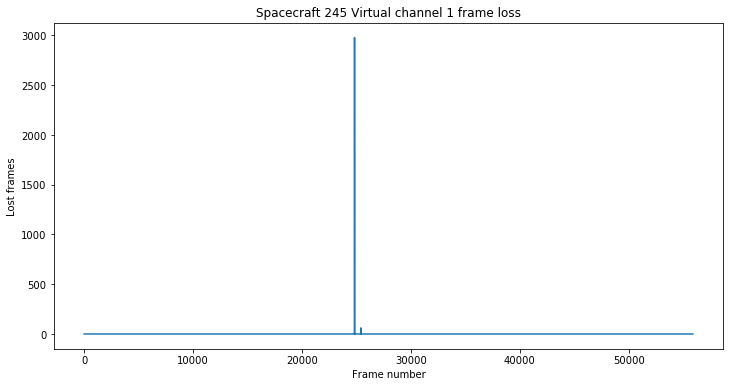

In [31]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(np.diff(fc) - 1)
plt.title('Spacecraft 245 Virtual channel 1 frame loss')
plt.ylabel('Lost frames')
plt.xlabel('Frame number');

In [32]:
[a.primary_header for a in sc245_vc1[:10]]

[Container(transfer_frame_version_number=1, spacecraft_id=245, virtual_channel_id=1, virtual_channel_frame_count=1409851, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=245, virtual_channel_id=1, virtual_channel_frame_count=1409852, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=245, virtual_channel_id=1, virtual_channel_frame_count=1409853, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=245, virtual_channel_id=1, virtual_channel_frame_count=1409854, replay_flag=False, vc_frame_count_usage_flag=False, rsvd_spare=0, vc_framecount_cycle=0),
 Container(transfer_frame_version_number=1, spacecraft_id=245, virtual_channel_id=1, virtual_channel_frame_count=1409855, replay_flag=False, vc_frame_co

In [33]:
sc245_vc1_timestamps = get_timestamps(sc245_vc1)

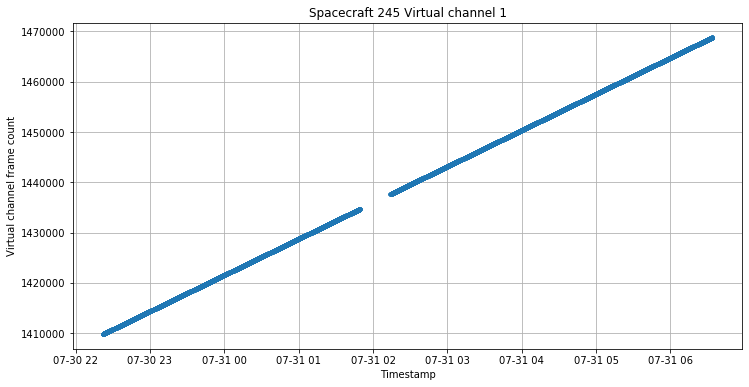

In [34]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(sc245_vc1_timestamps, fc, '.')
plt.title('Spacecraft 245 Virtual channel 1')
plt.xlabel('Timestamp')
plt.ylabel('Virtual channel frame count')
plt.grid();

In [35]:
{hex(a.insert_zone.unknown) for a in sc245_vc1}

{'0x4aaa'}

In [36]:
sc245_vc1_packets = list(ccsds.extract_space_packets(sc245_vc1, 245, 1, get_timestamps = True))

/home/daniel/jupyter_notebooks/Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 245 VC 1] Broken stream. Last frame count 1434674, current frame count 1437655
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/jupyter_notebooks/Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 245 VC 1] Broken stream. Last frame count 1437655, current frame count 1437658
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_count}, current frame count {frame_count_new}')
/home/daniel/jupyter_notebooks/Tianwen/ccsds.py:79: UserWarning: [Space Packet extractor Spacecraft 245 VC 1] Broken stream. Last frame count 1437659, current frame count 1437662
  warnings.warn(f'[Space Packet extractor Spacecraft {sc_id} VC {virtual_channel}] Broken stream. Last frame count {frame_c

In [37]:
sc245_vc1_sp_headers = [ccsds.SpacePacketPrimaryHeader.parse(p[0]) for p in sc245_vc1_packets]

In [38]:
sc245_vc1_apids = collections.Counter([p.APID for p in sc245_vc1_sp_headers])
sc245_vc1_apids

Counter({1280: 27943,
         455: 13972,
         8: 3493,
         194: 3493,
         196: 3493,
         736: 1747,
         448: 1745,
         449: 27942,
         2: 27942,
         3: 27942,
         456: 13972,
         1281: 13972,
         1344: 1745,
         1536: 13971,
         768: 13971,
         1537: 3493,
         461: 873,
         204: 873,
         200: 873,
         832: 13970,
         1285: 873,
         1282: 6987,
         1024: 6987,
         1025: 6986,
         14: 6985,
         202: 3493,
         1283: 3492,
         1284: 3492,
         452: 3493,
         450: 3492,
         462: 3492,
         454: 3491,
         451: 3494,
         460: 3490,
         192: 3492,
         1026: 1746,
         672: 1747,
         457: 1747,
         206: 873,
         208: 873,
         210: 873,
         212: 873,
         214: 873,
         458: 873,
         1286: 873,
         704: 1746,
         1027: 873,
         198: 873,
         1287: 873,
         1028: 8

In [39]:
sc245_vc1_by_apid = {apid : [p for h,p in zip(sc245_vc1_sp_headers, sc245_vc1_packets)
                           if h.APID == apid] for apid in sc245_vc1_apids}

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


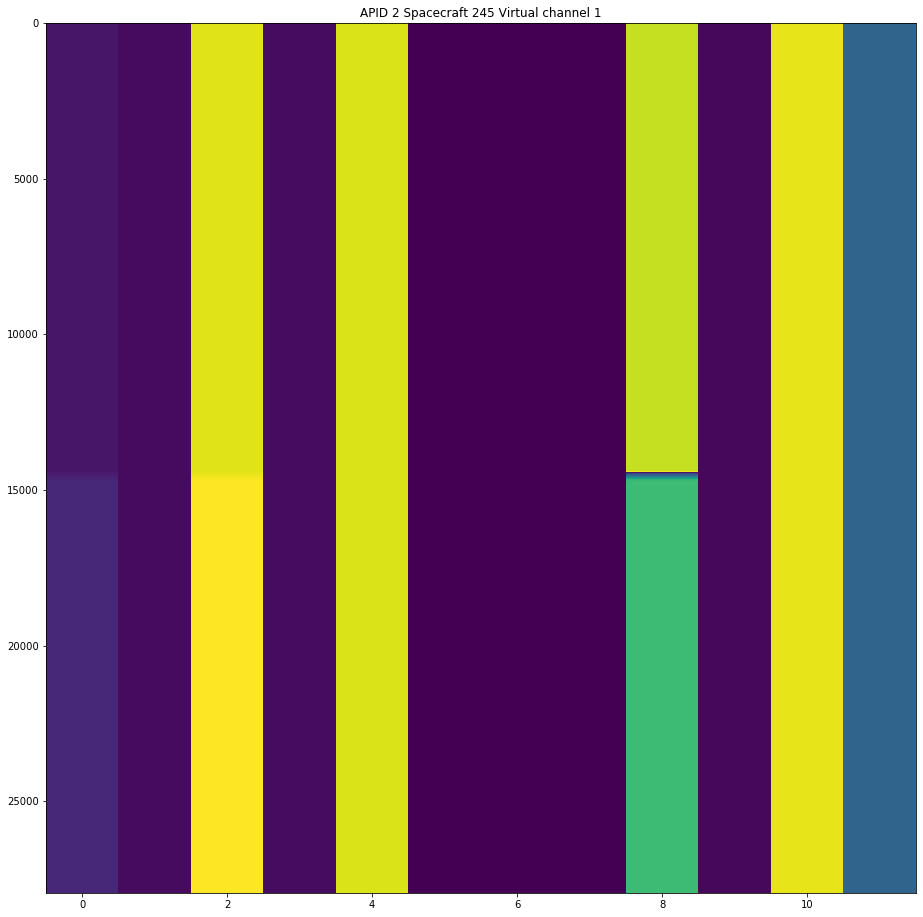

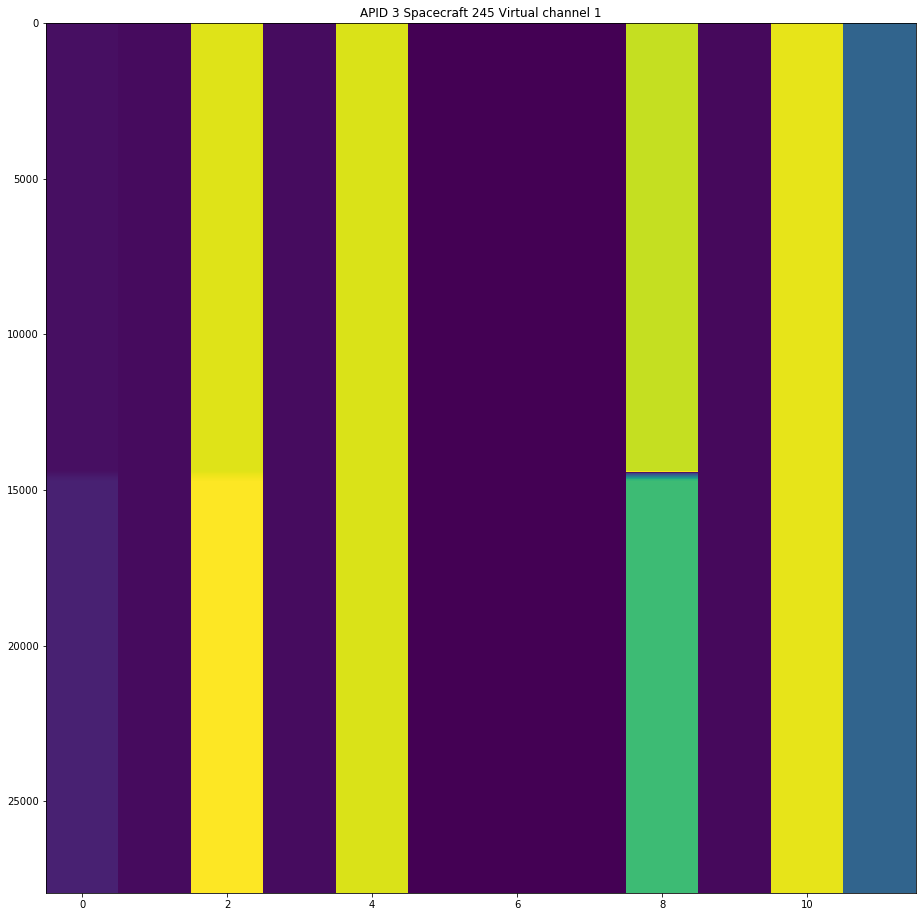

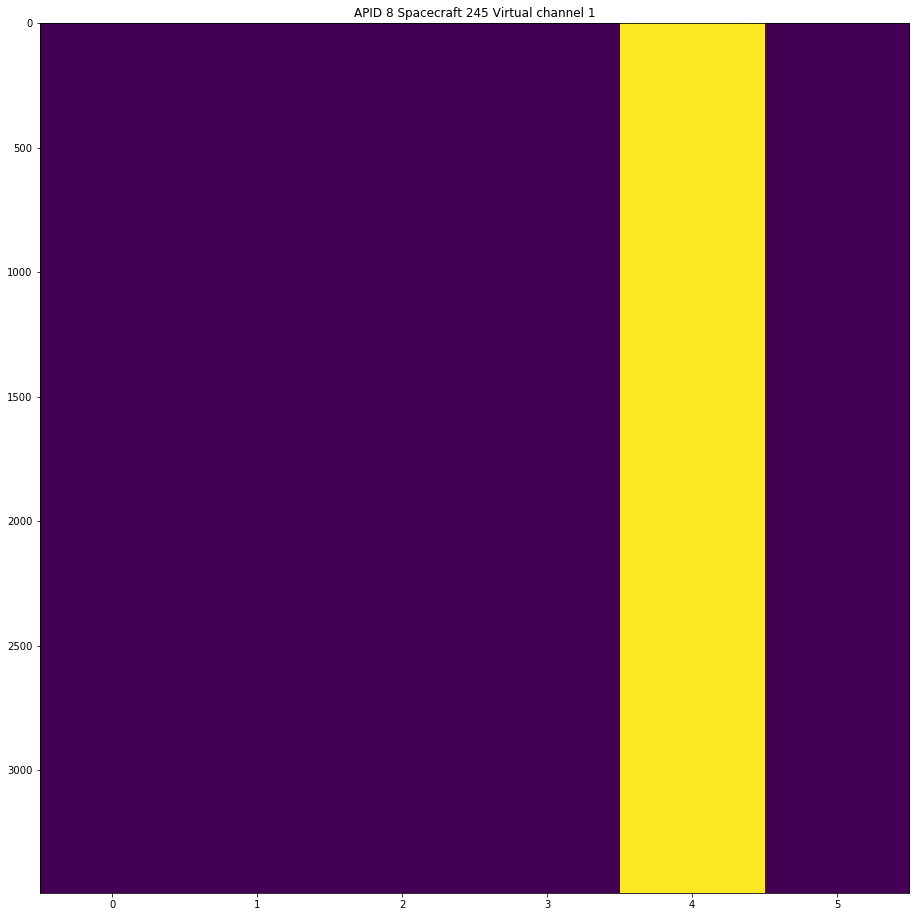

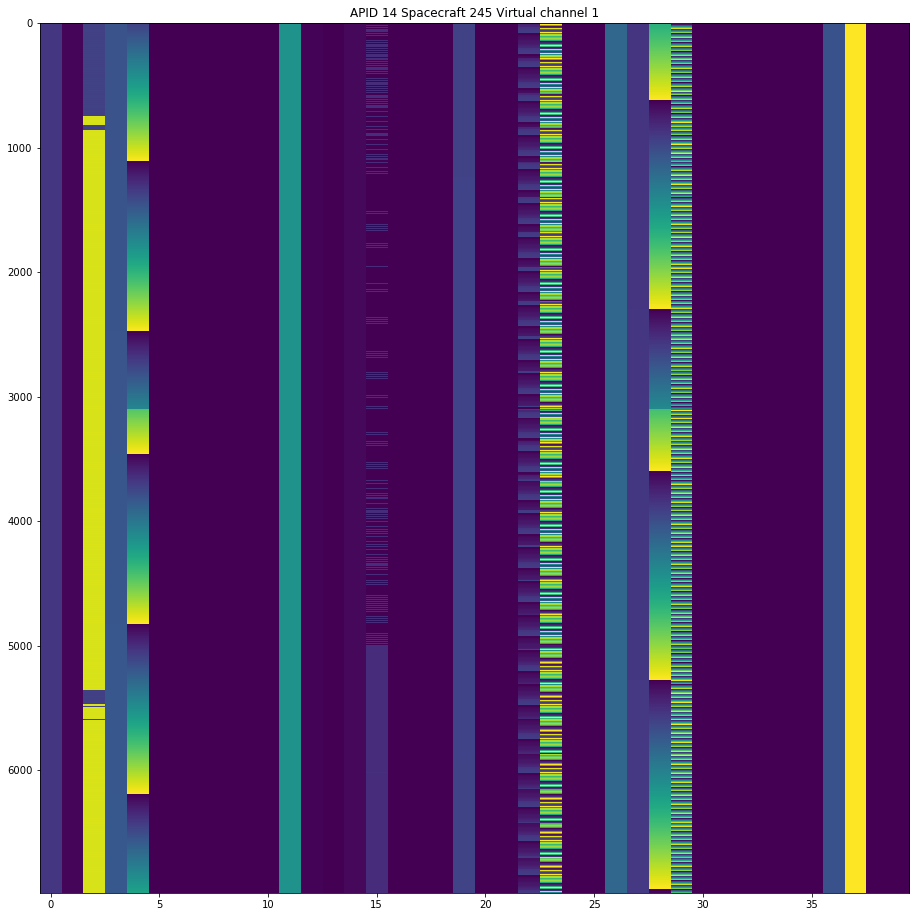

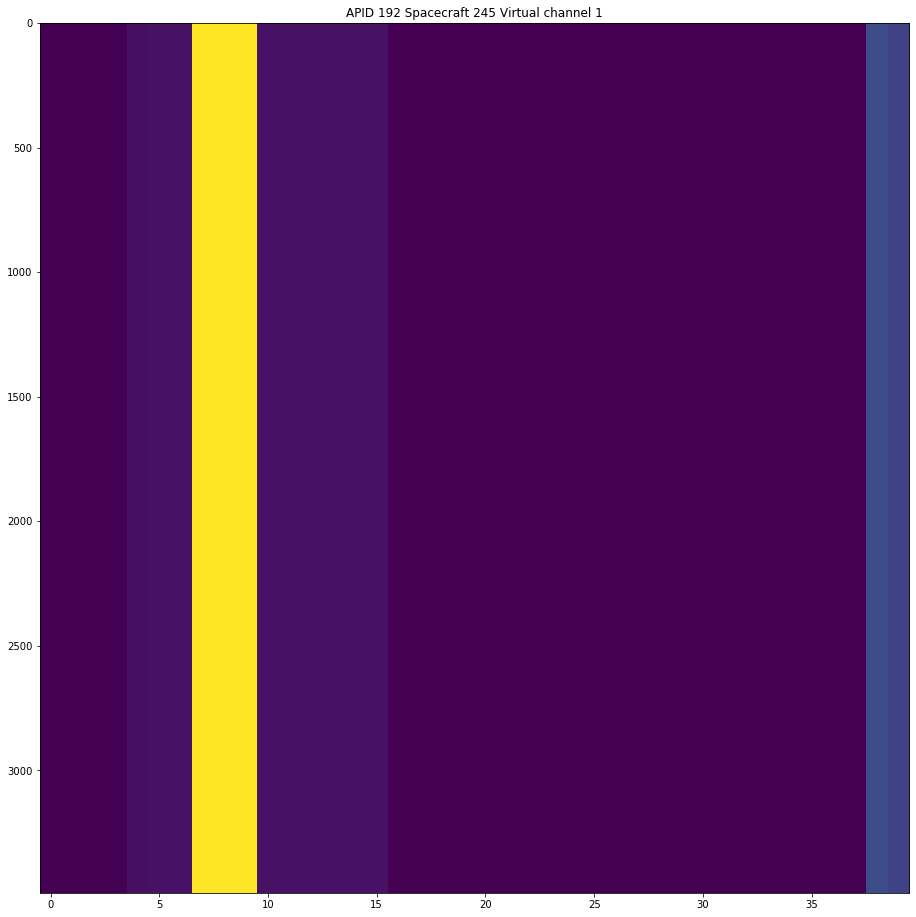

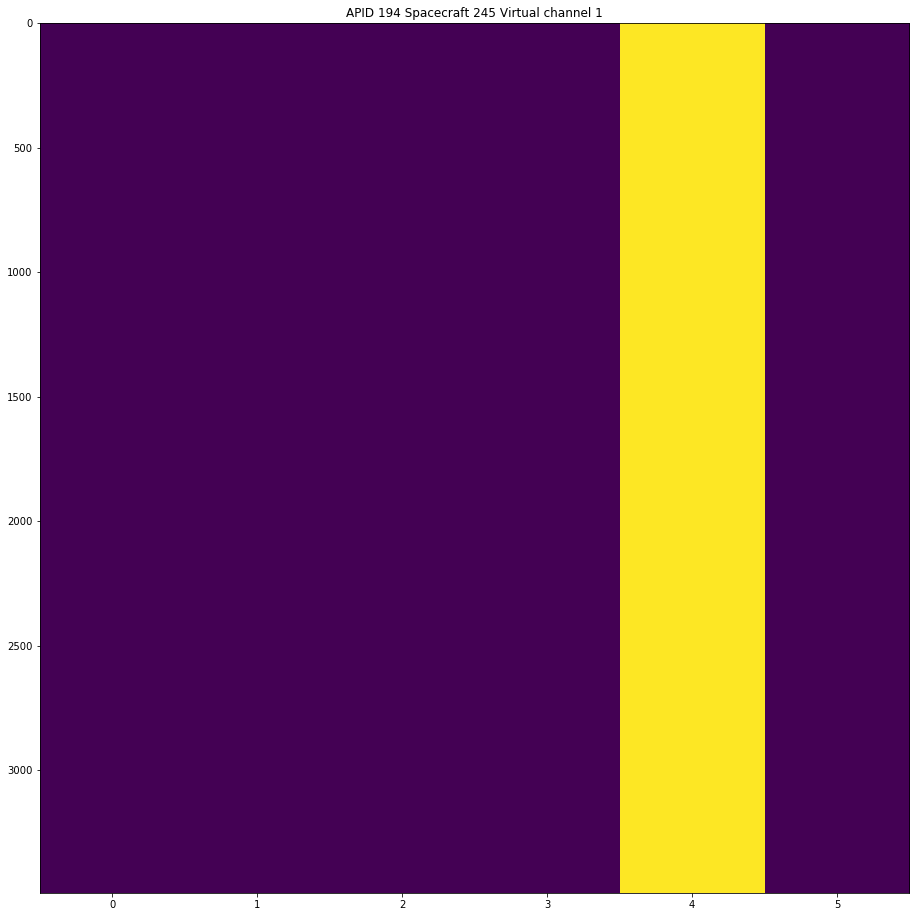

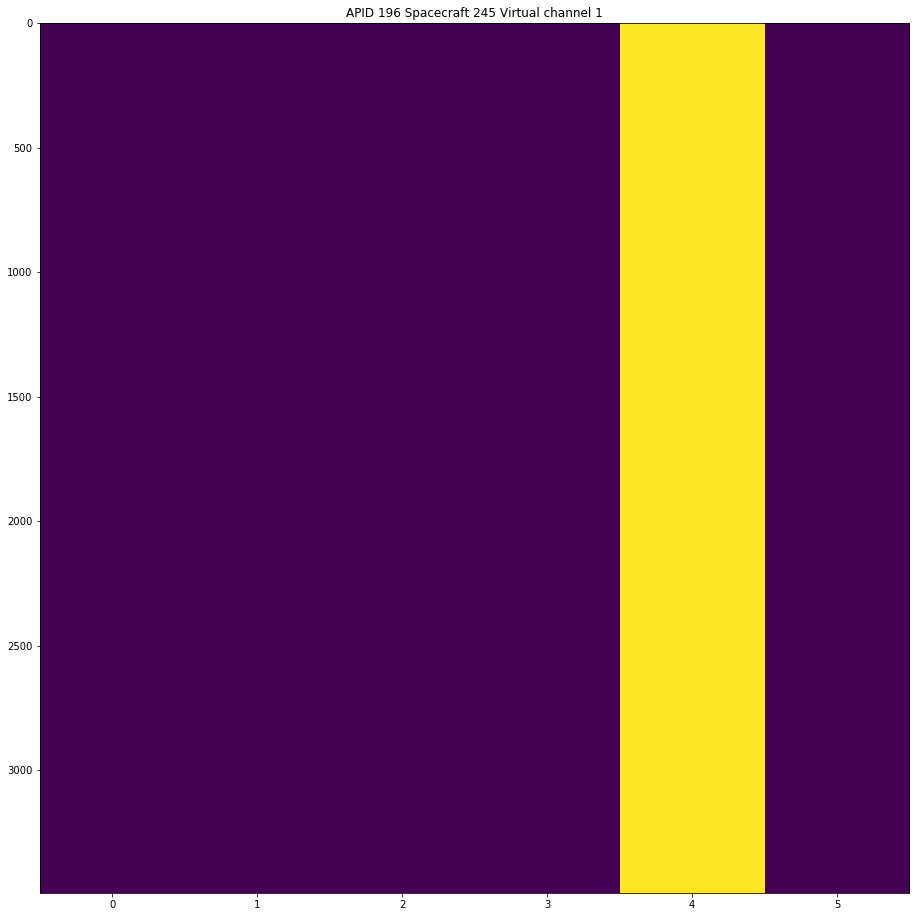

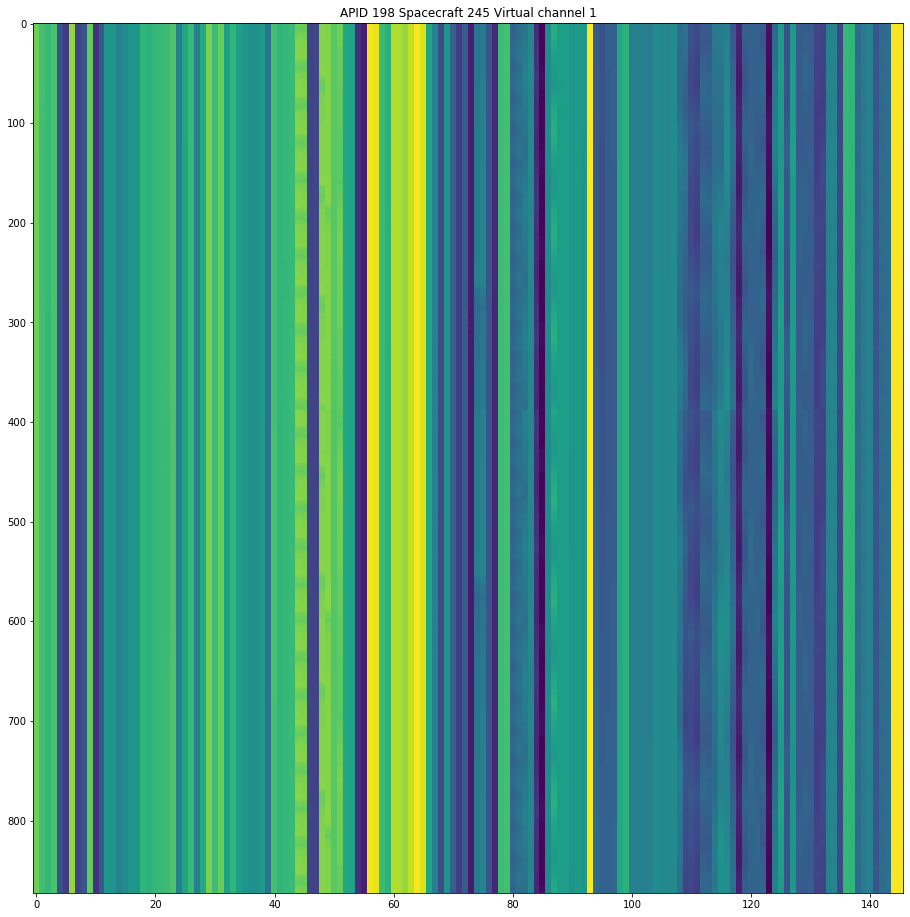

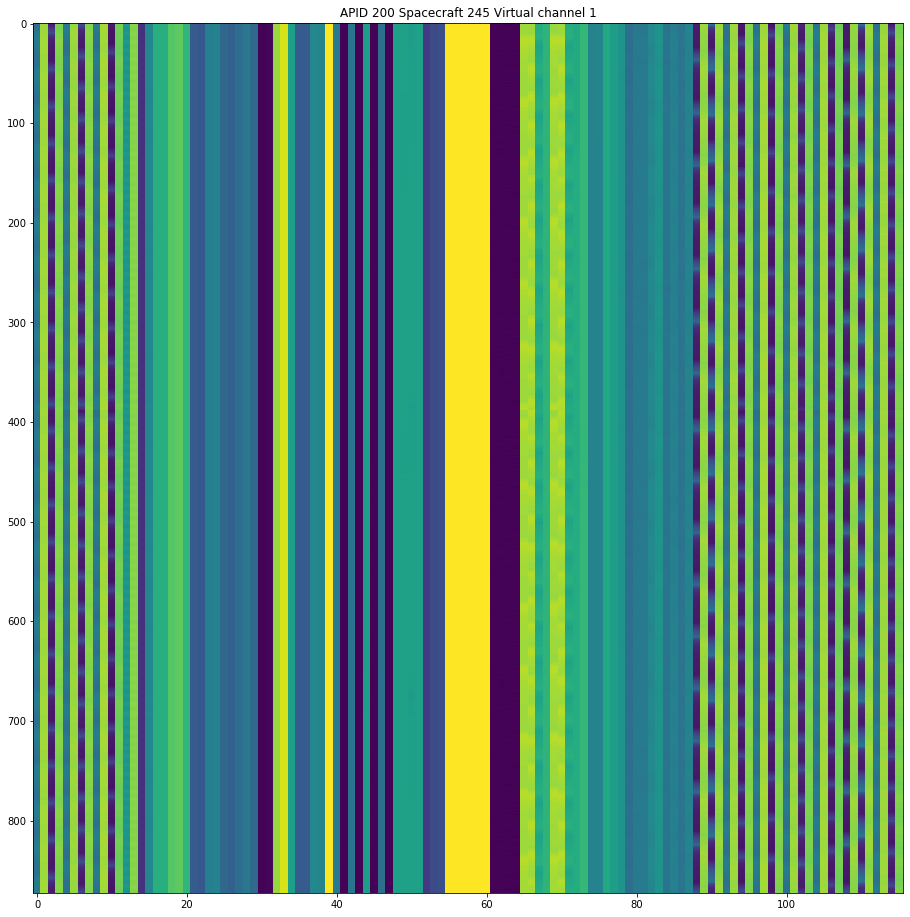

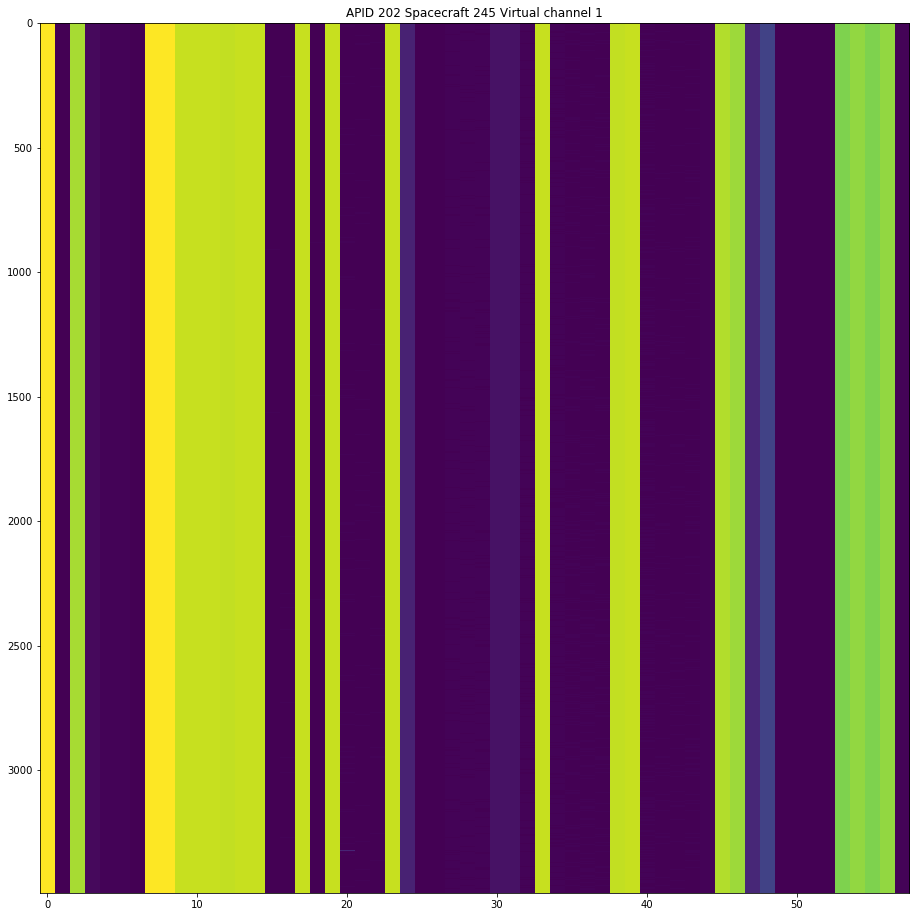

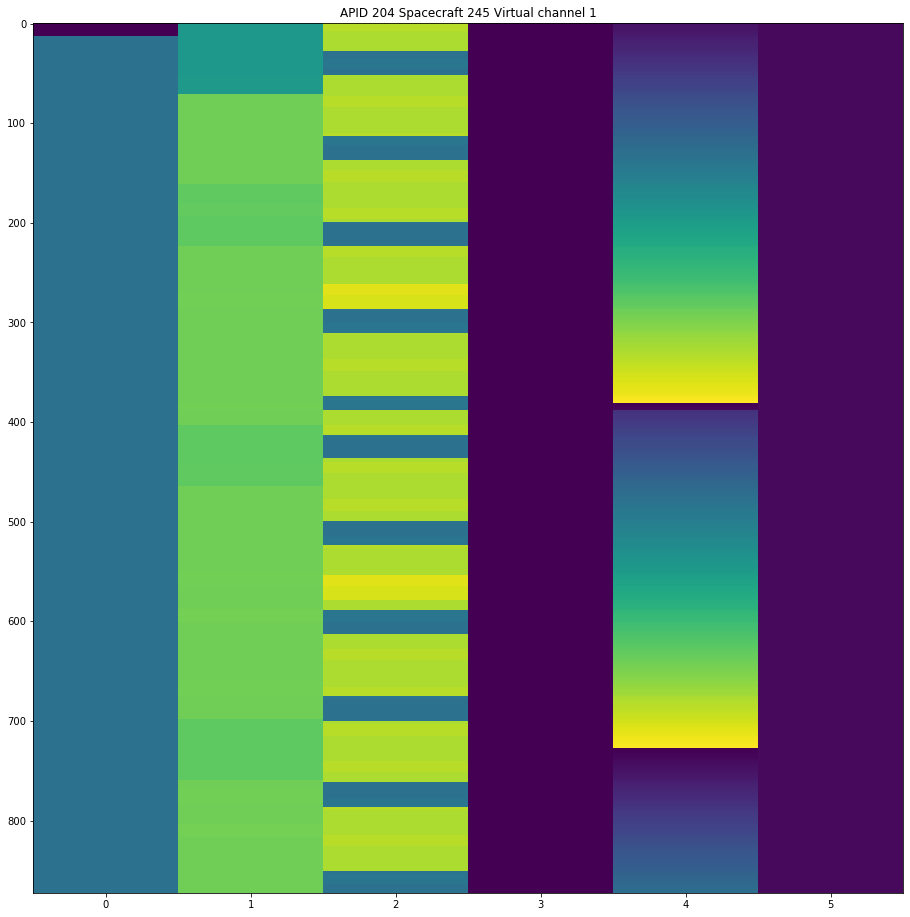

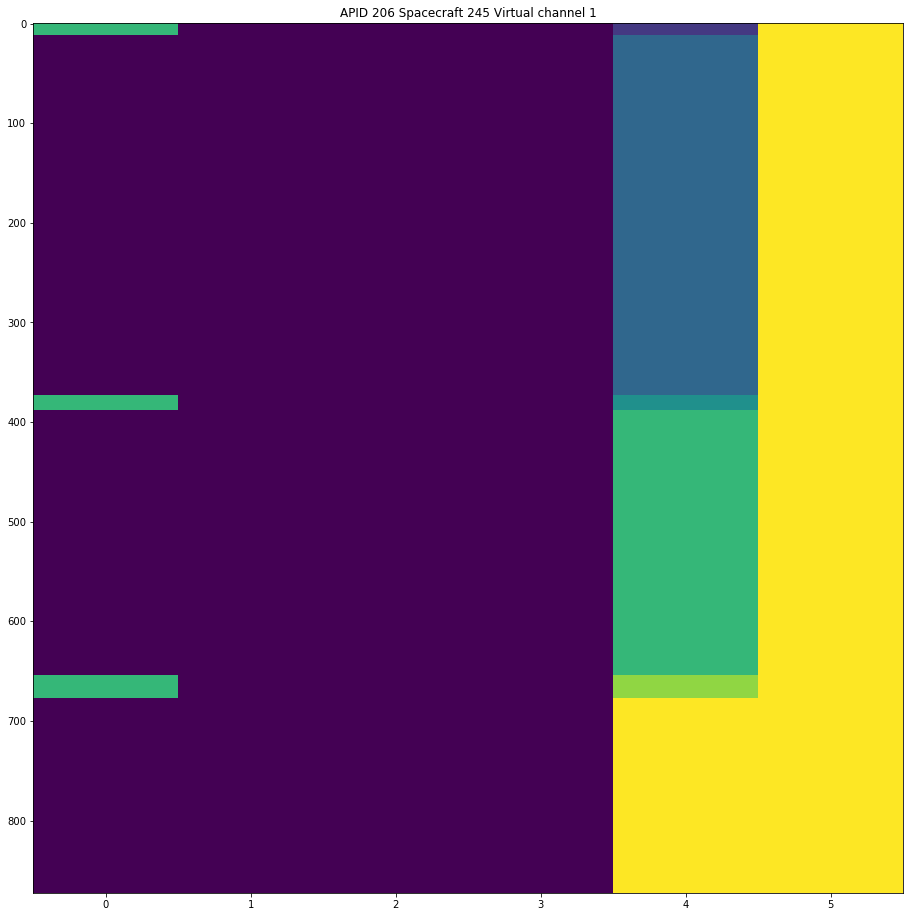

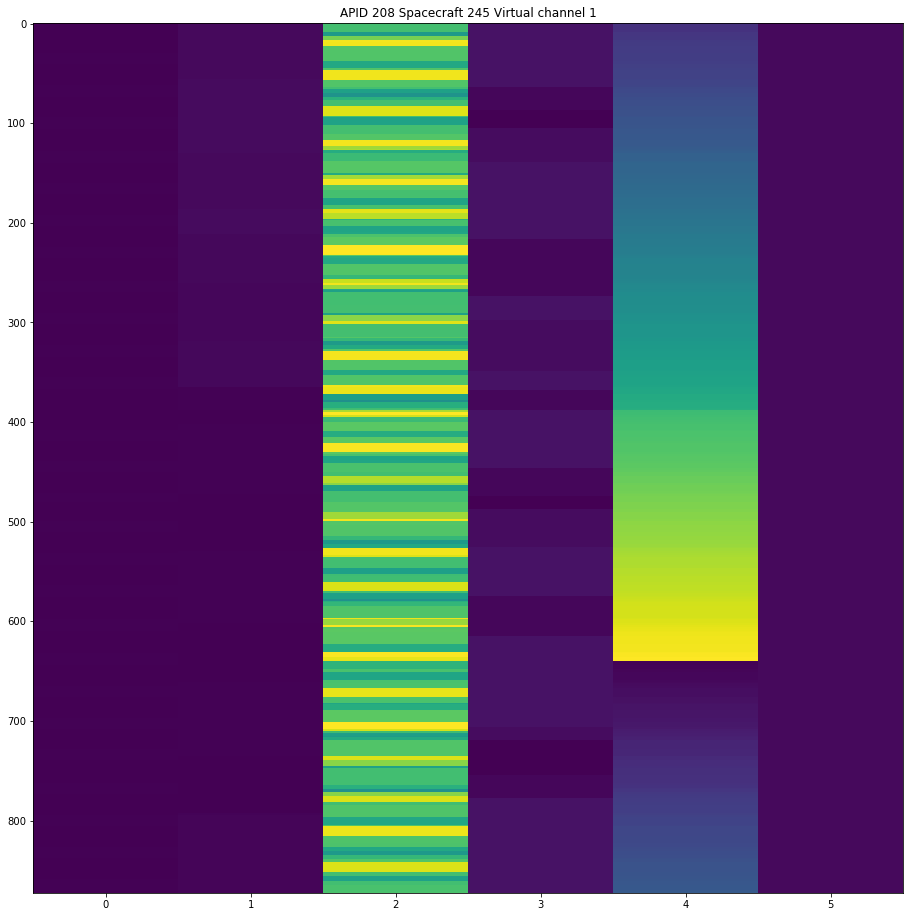

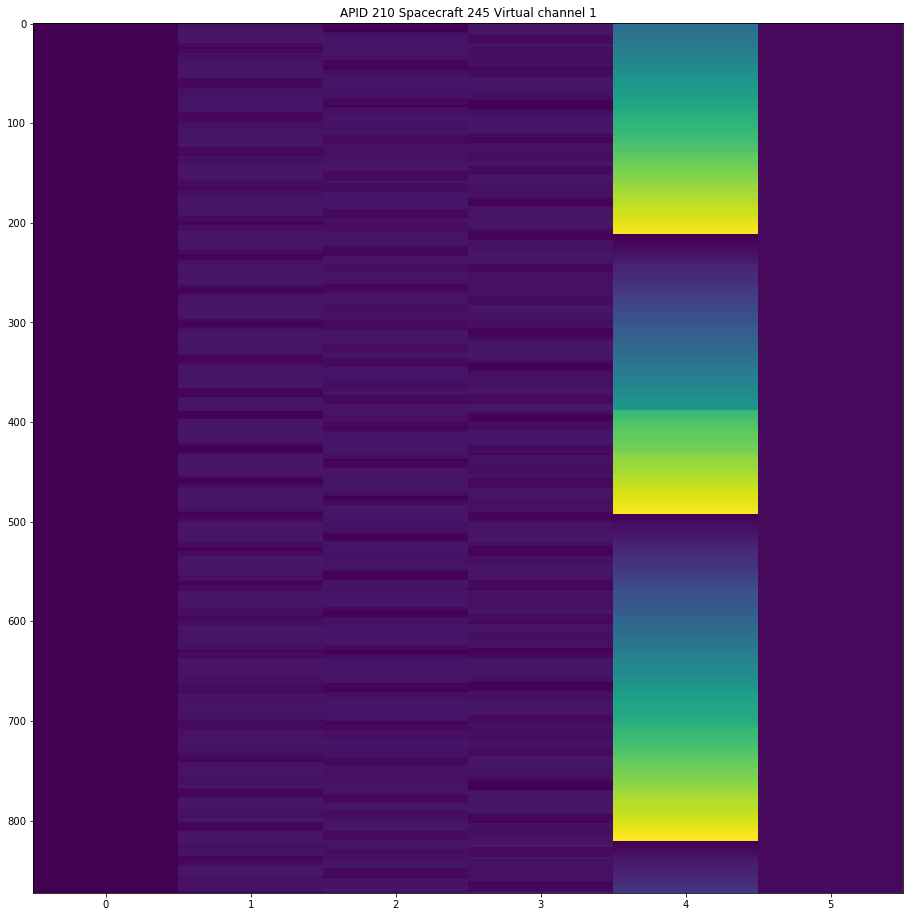

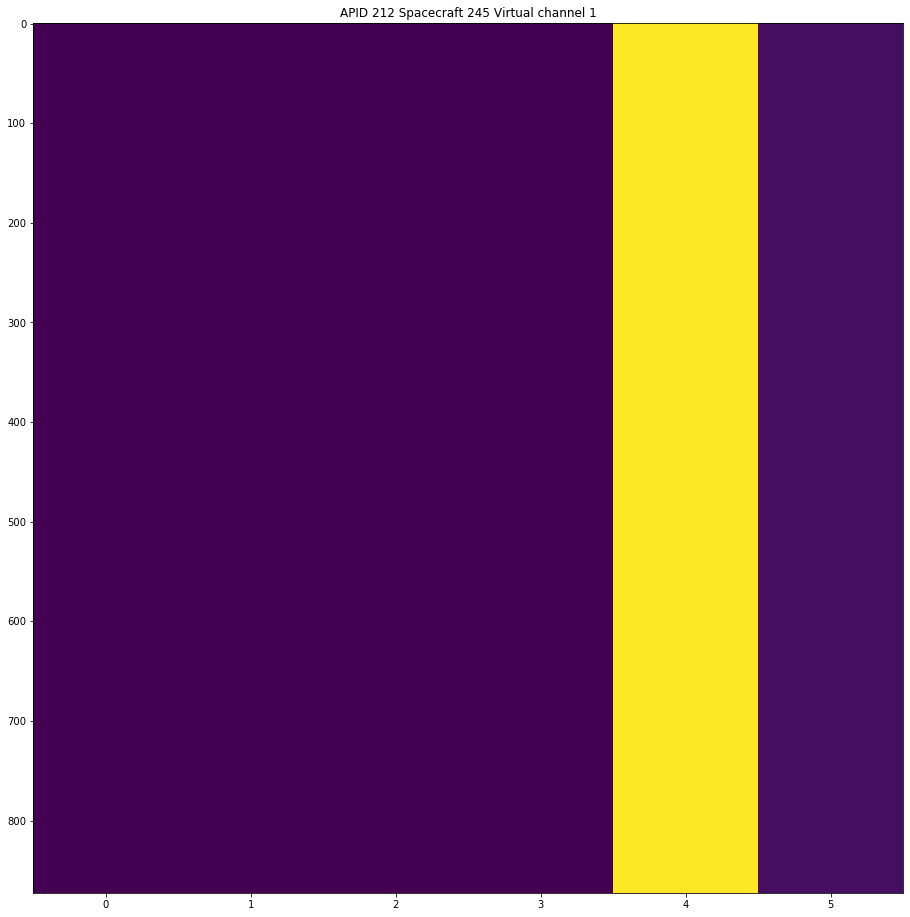

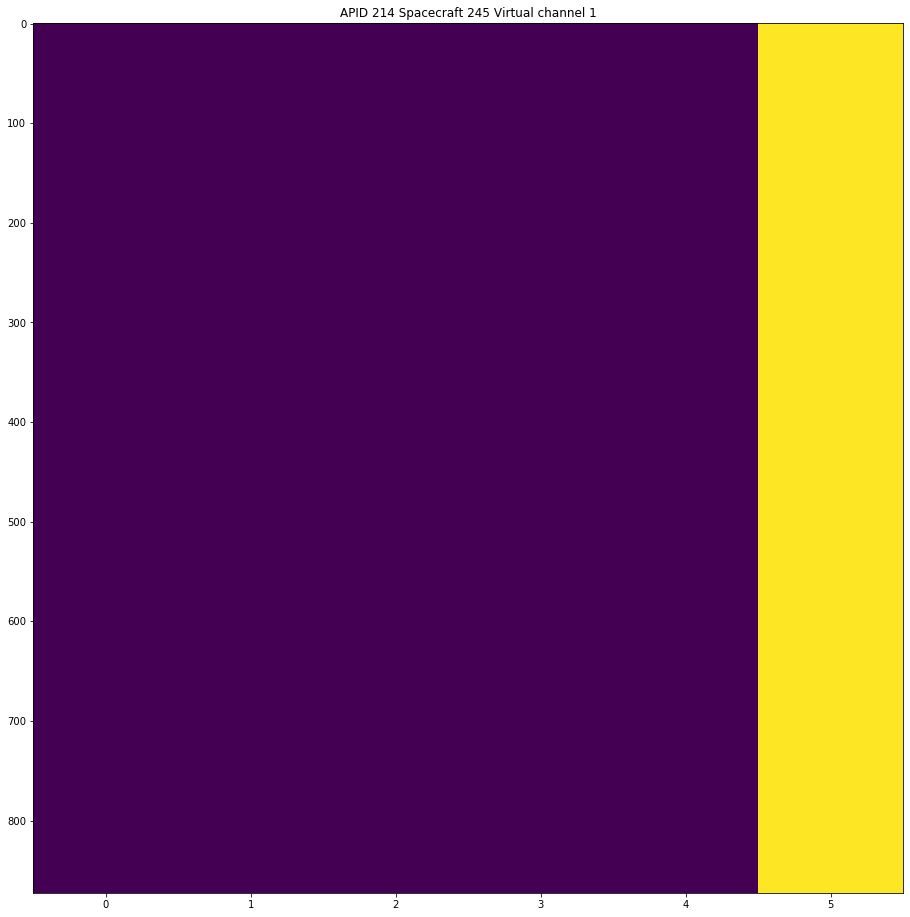

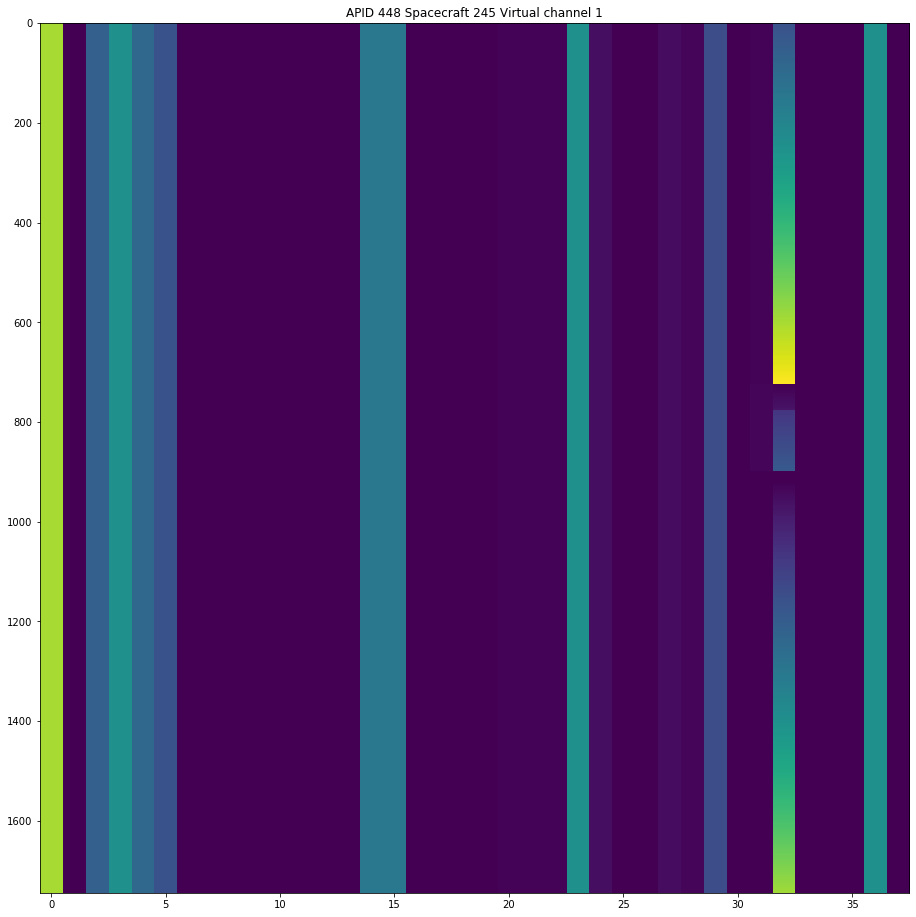

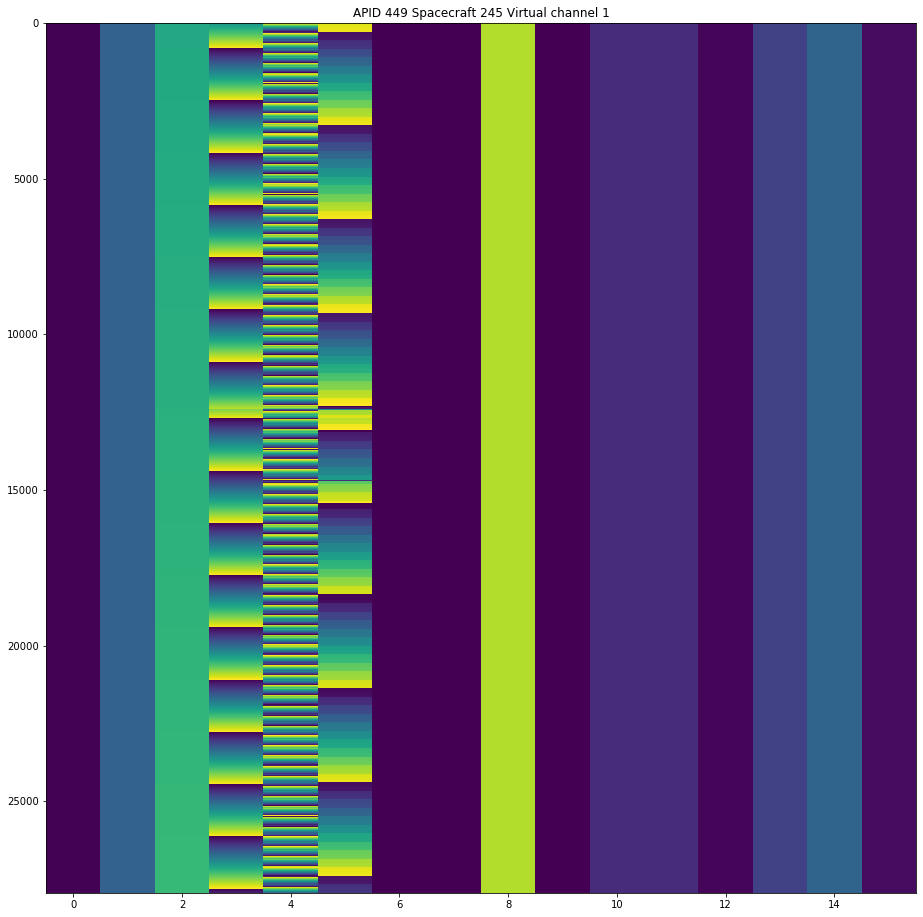

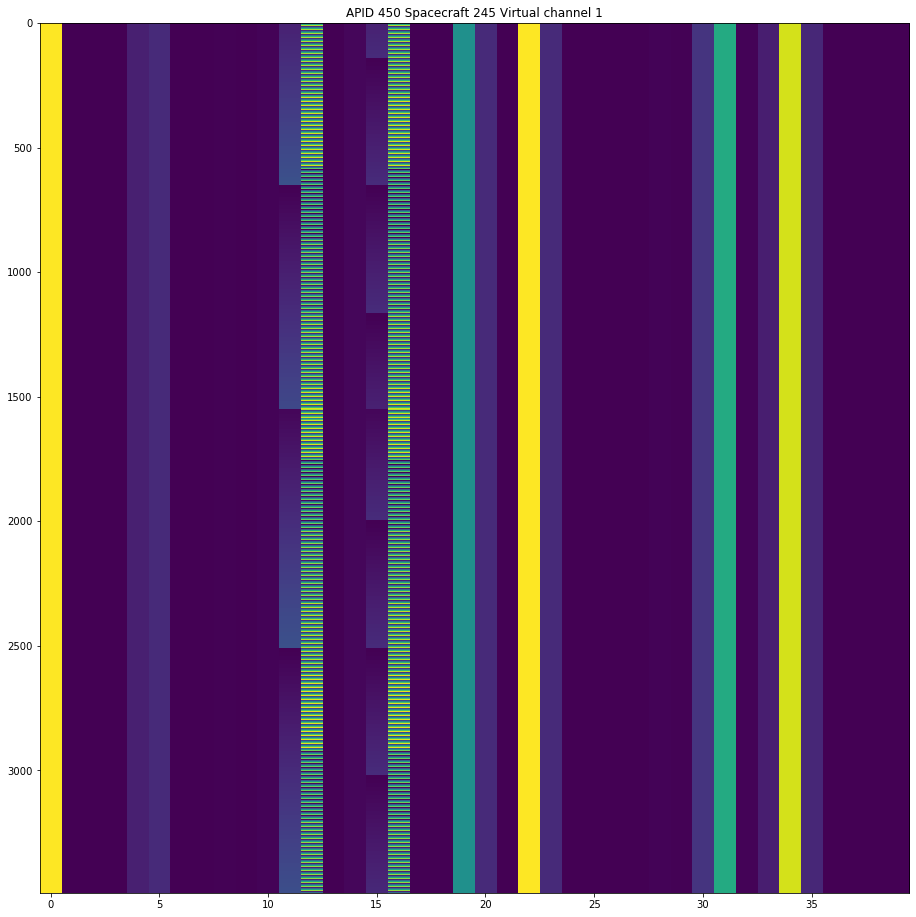

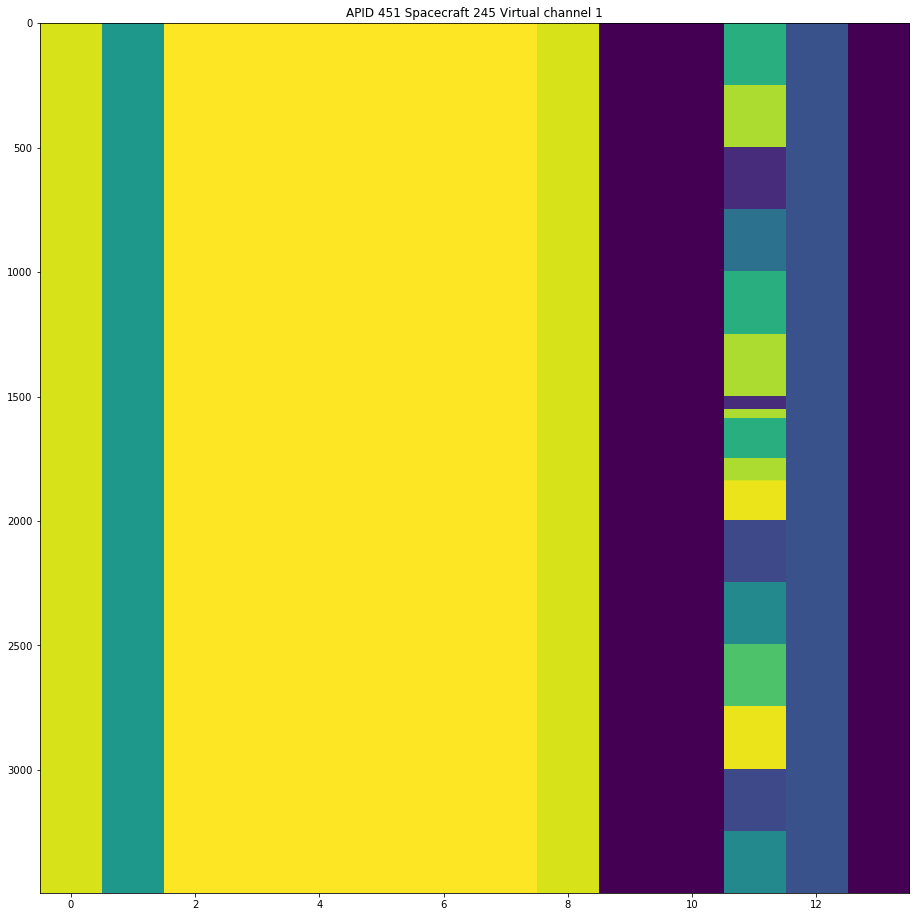

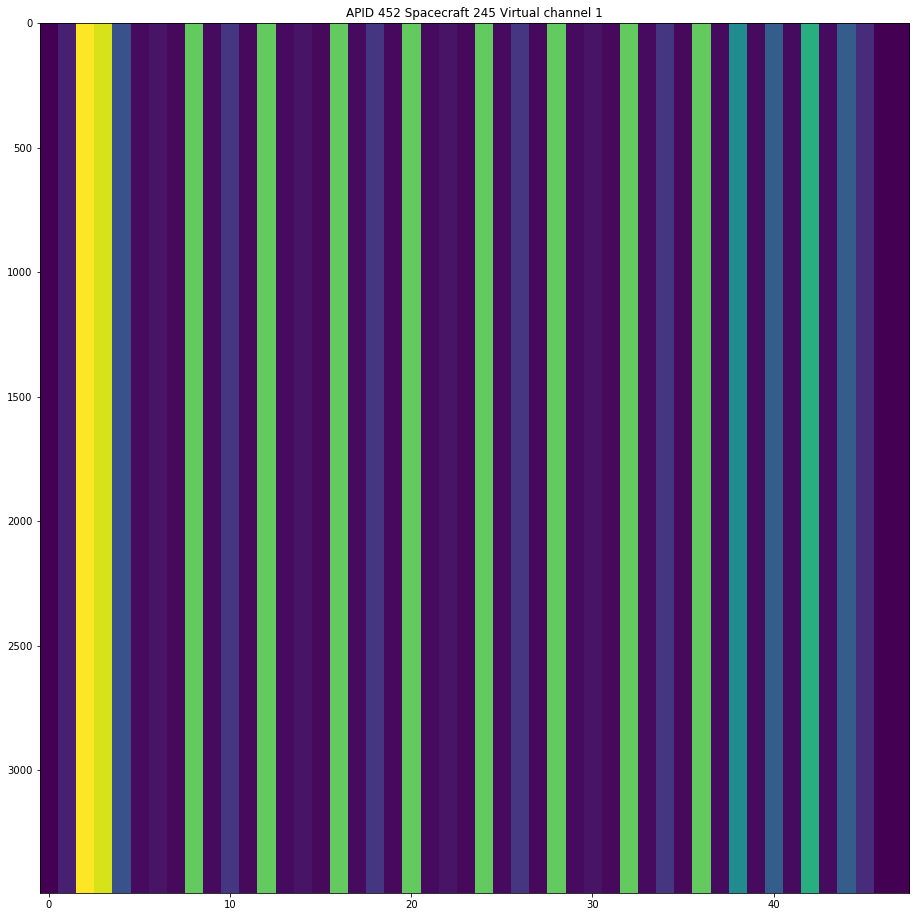

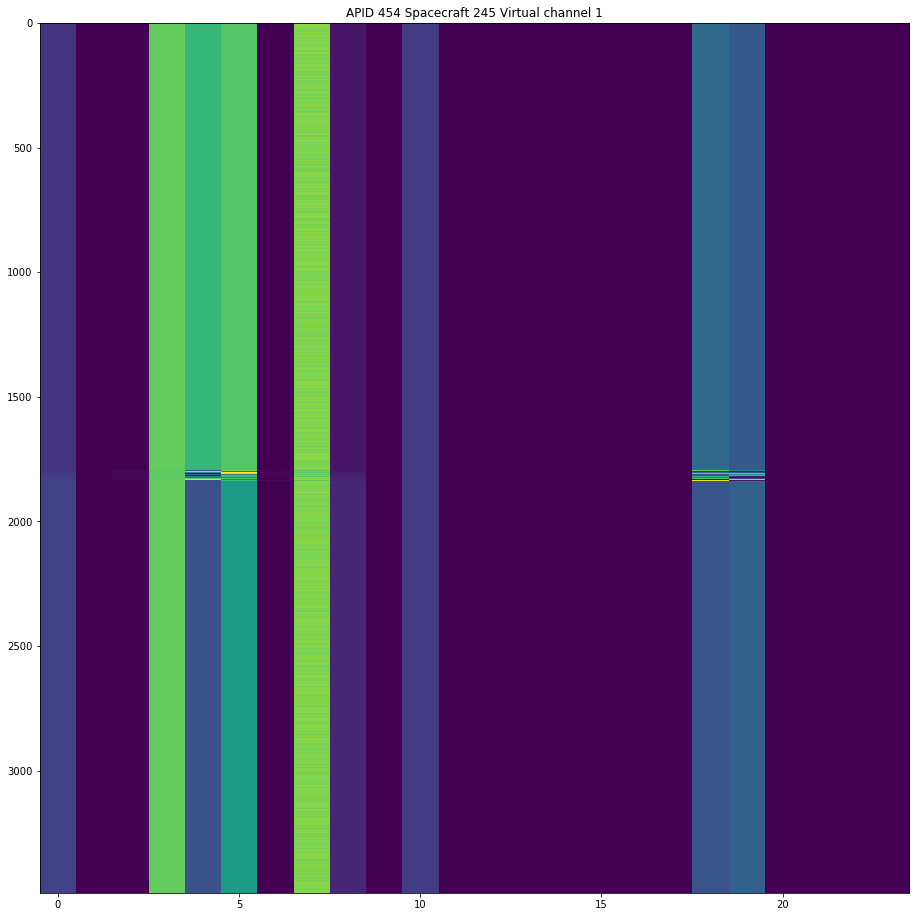

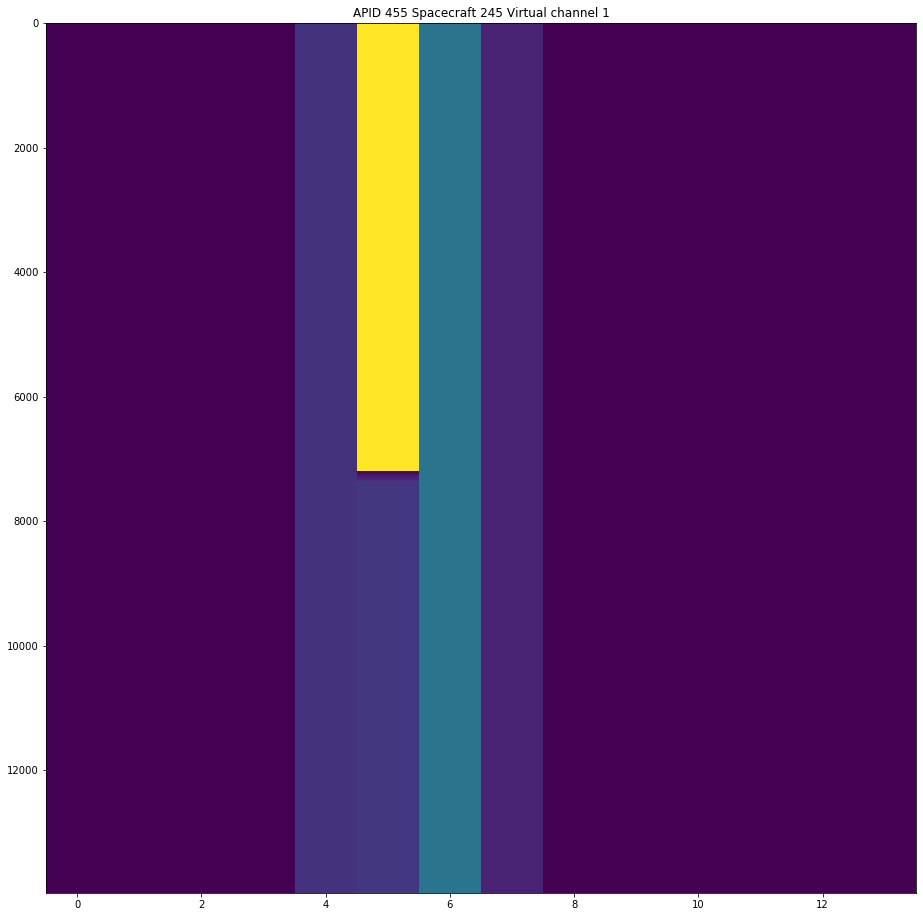

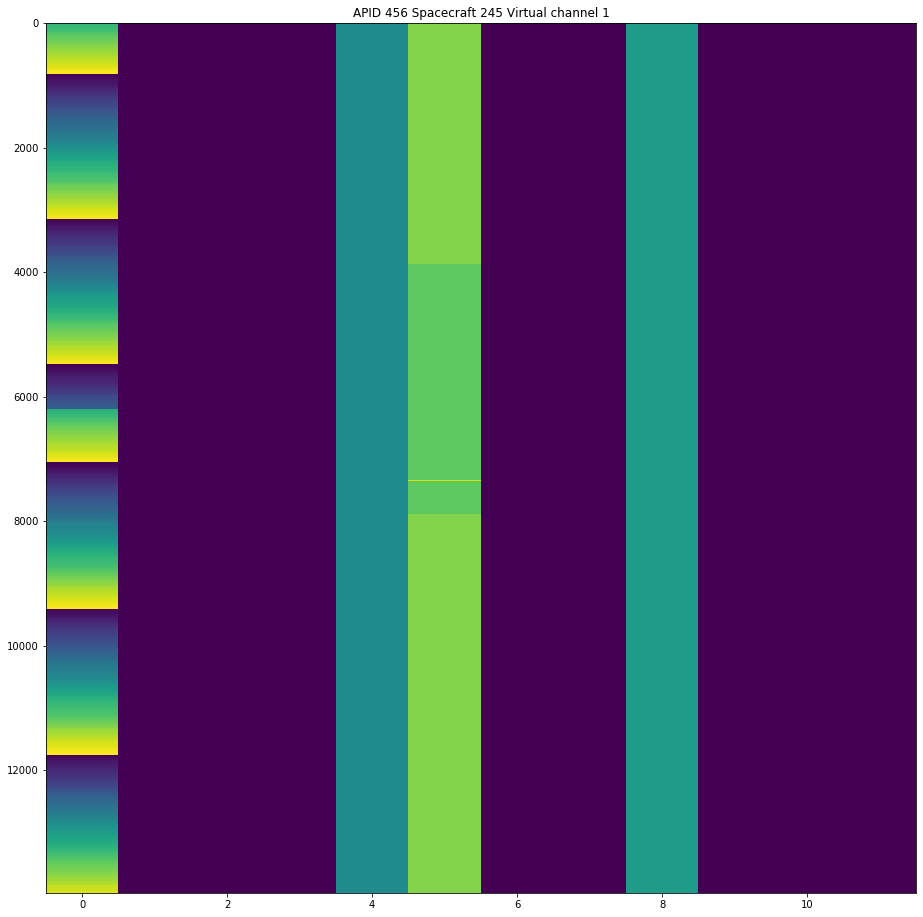

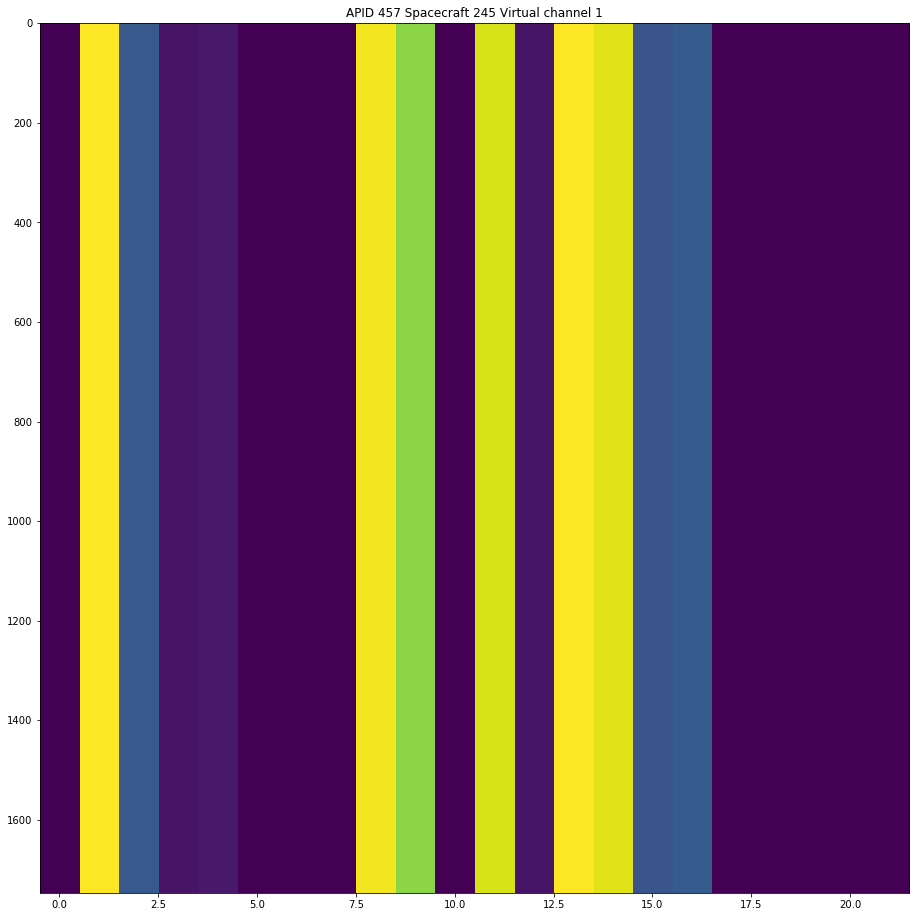

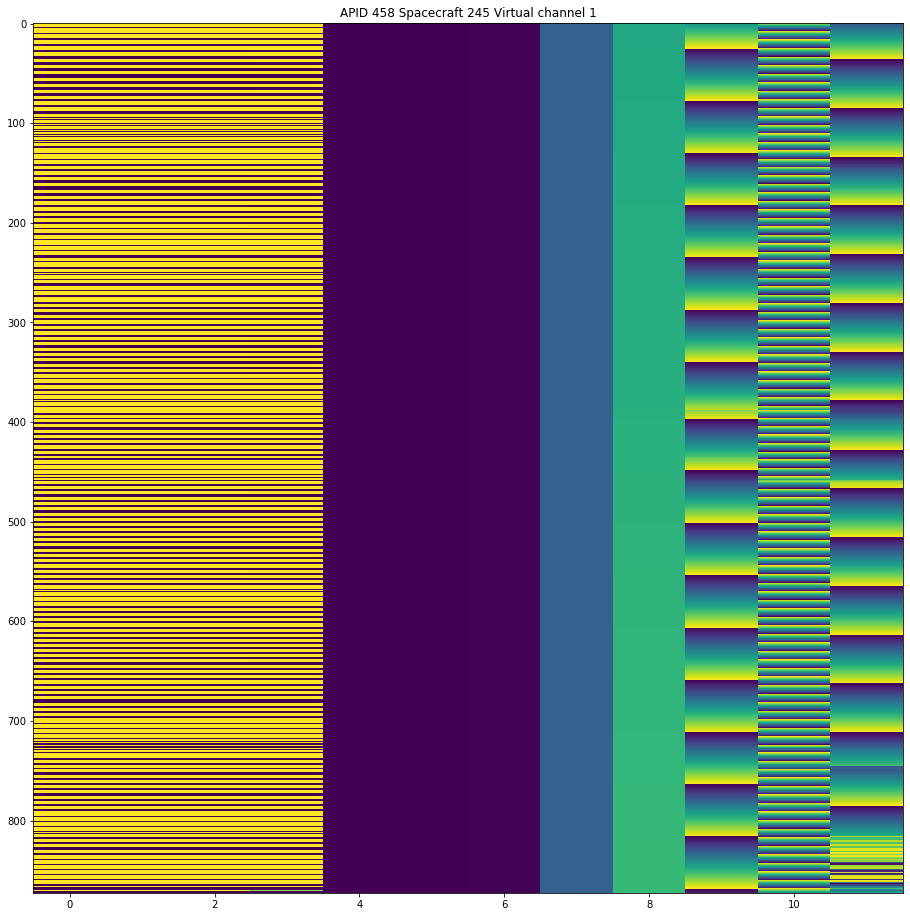

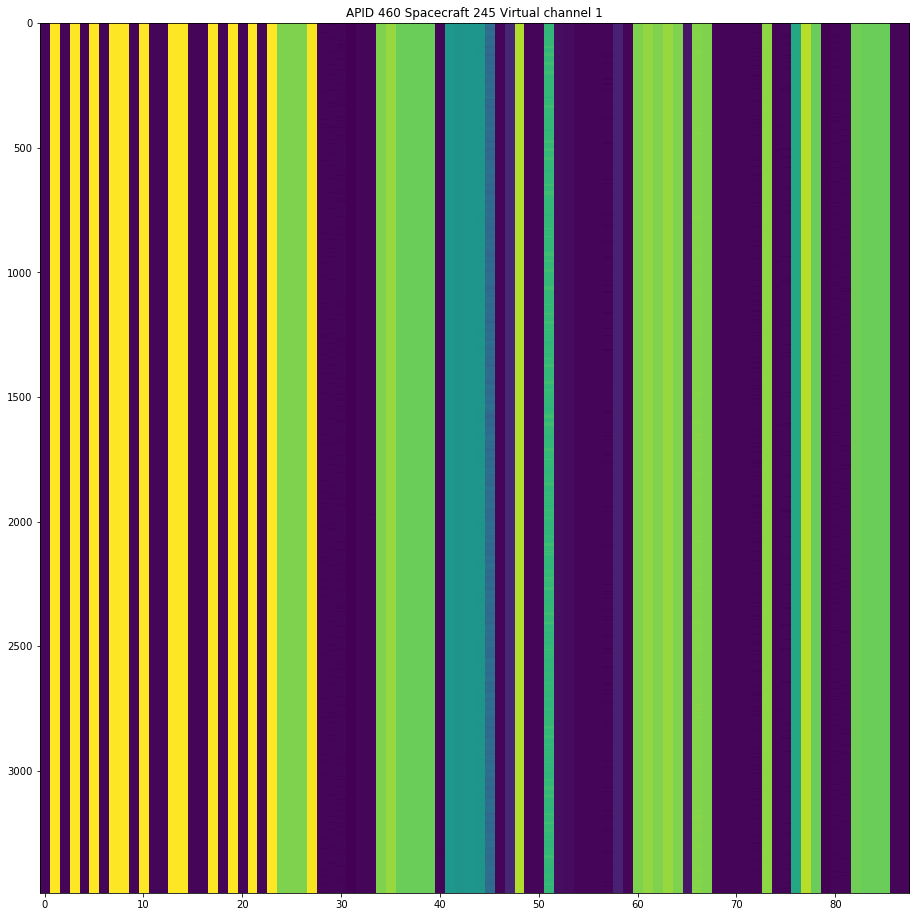

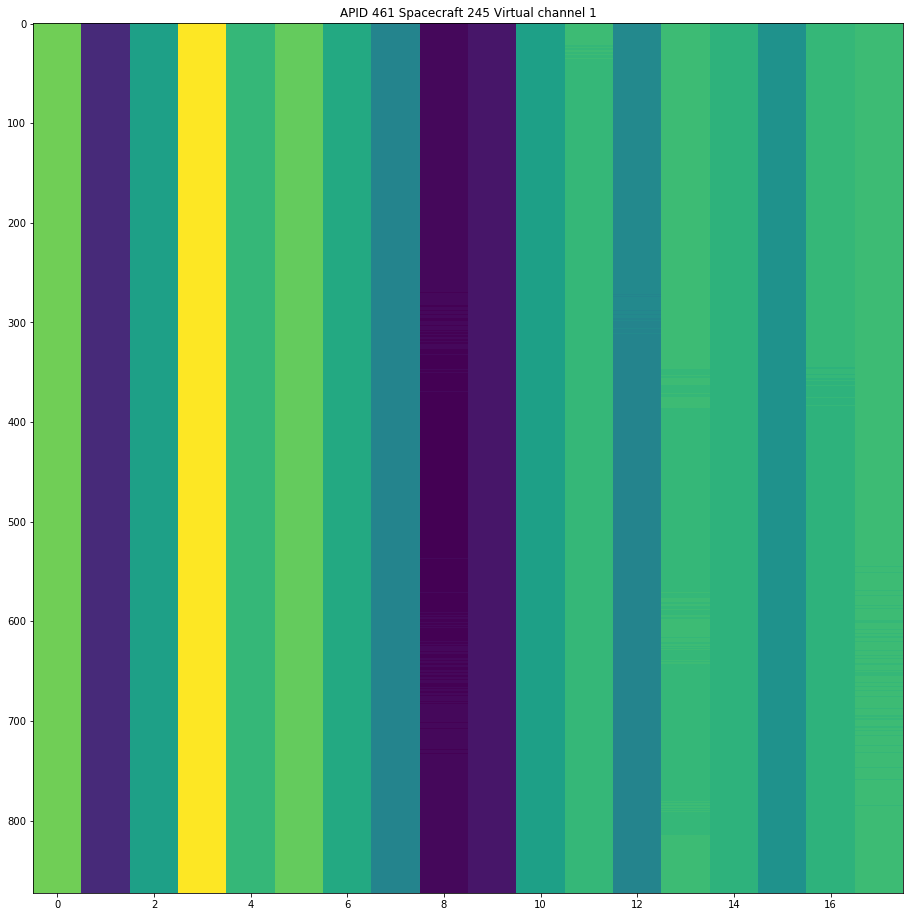

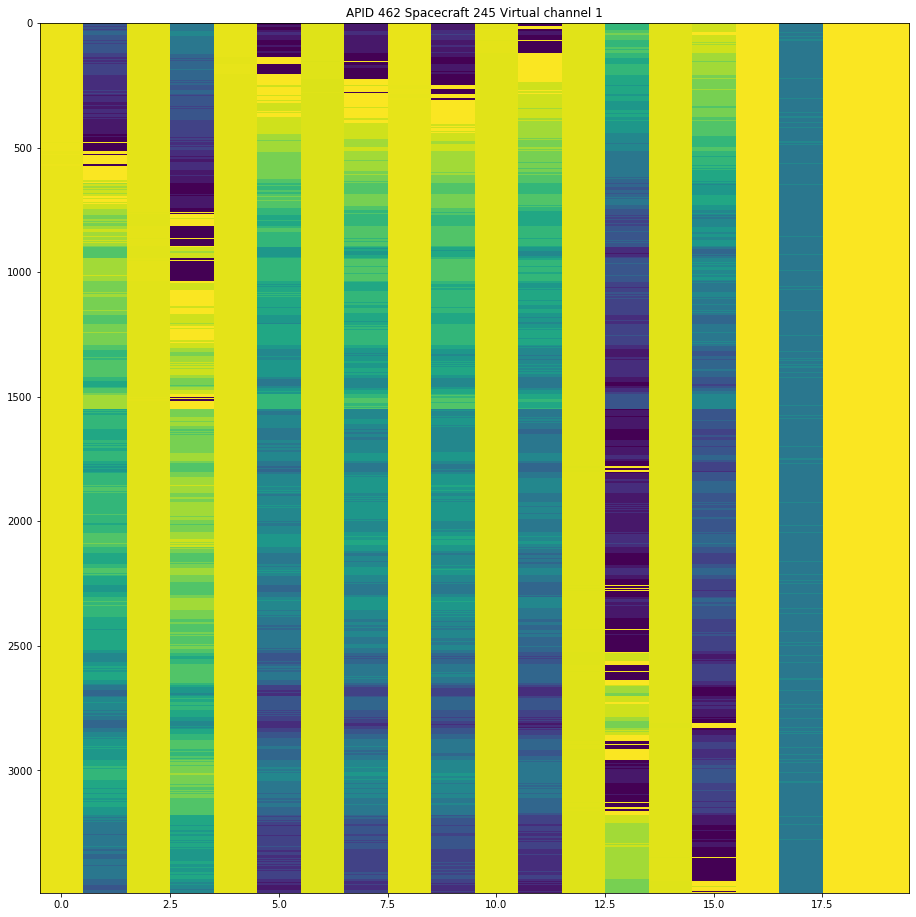

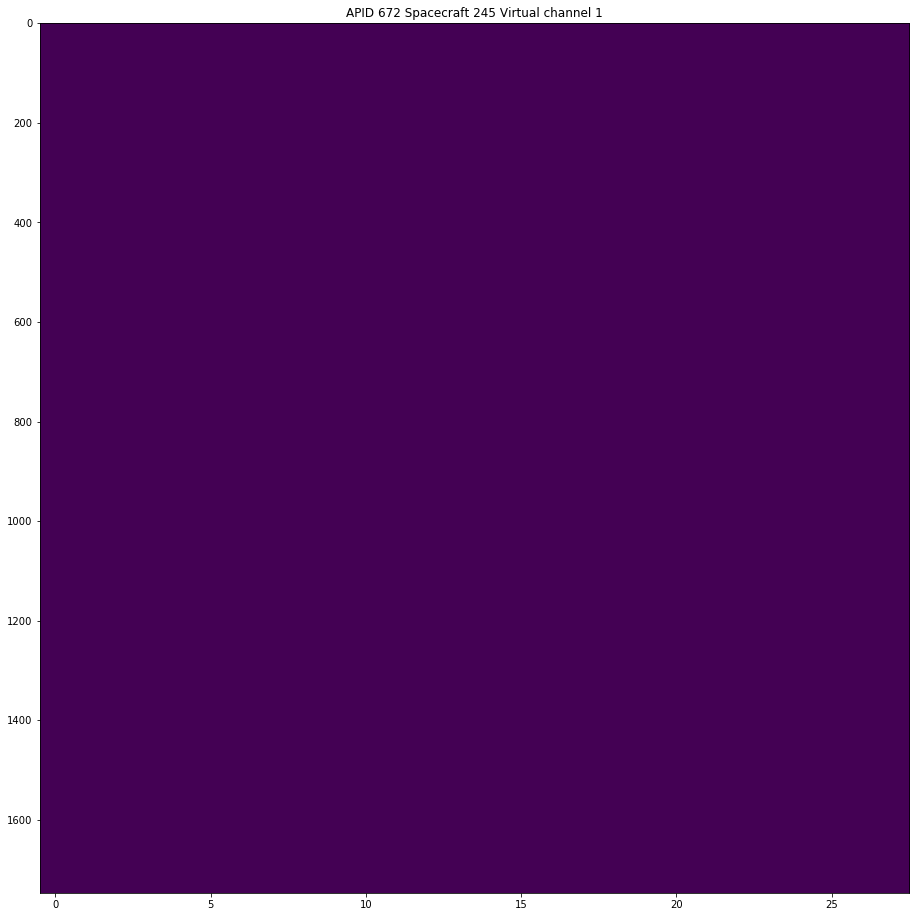

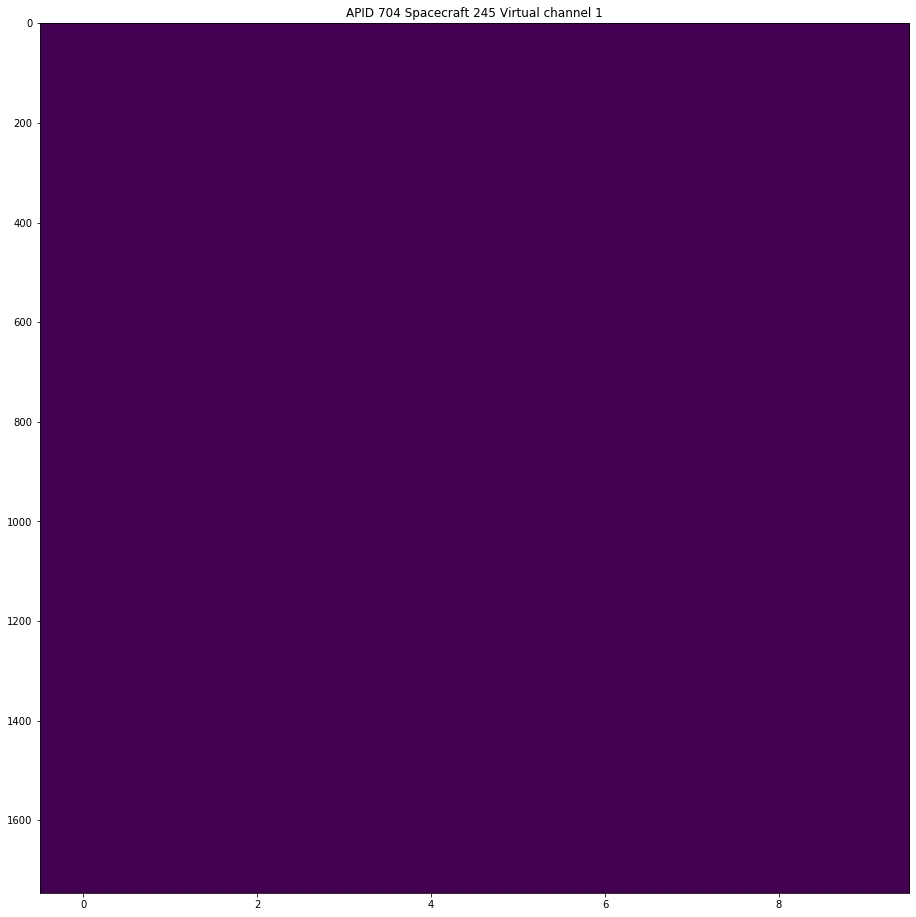

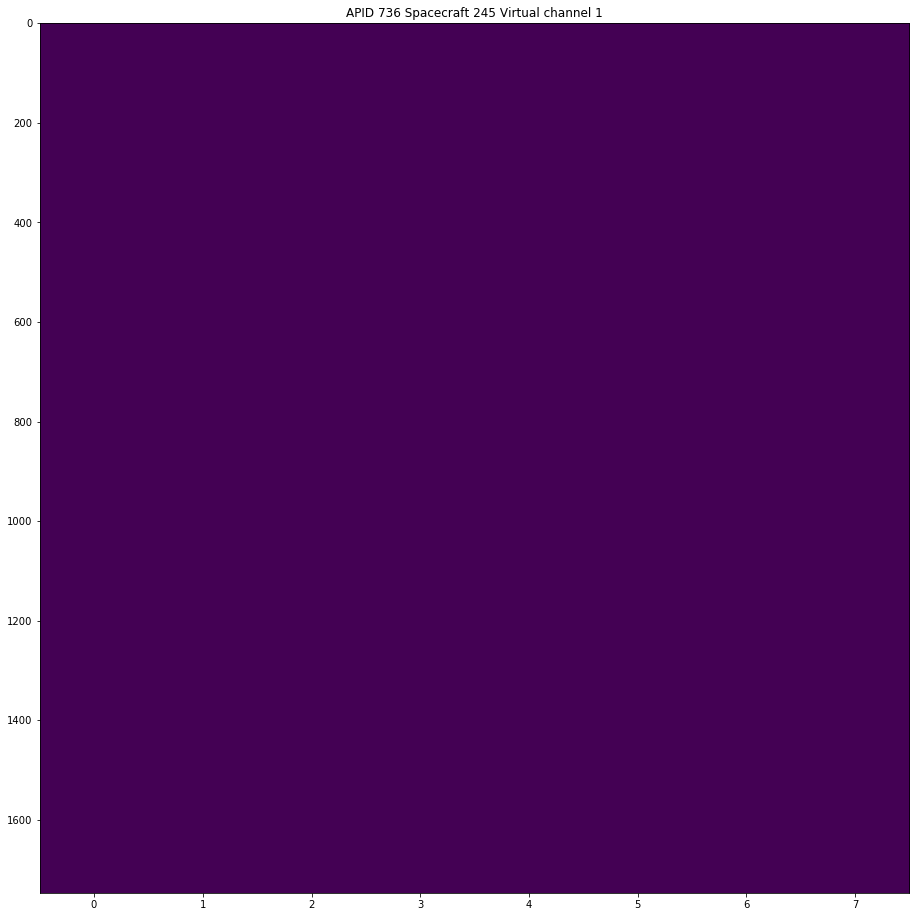

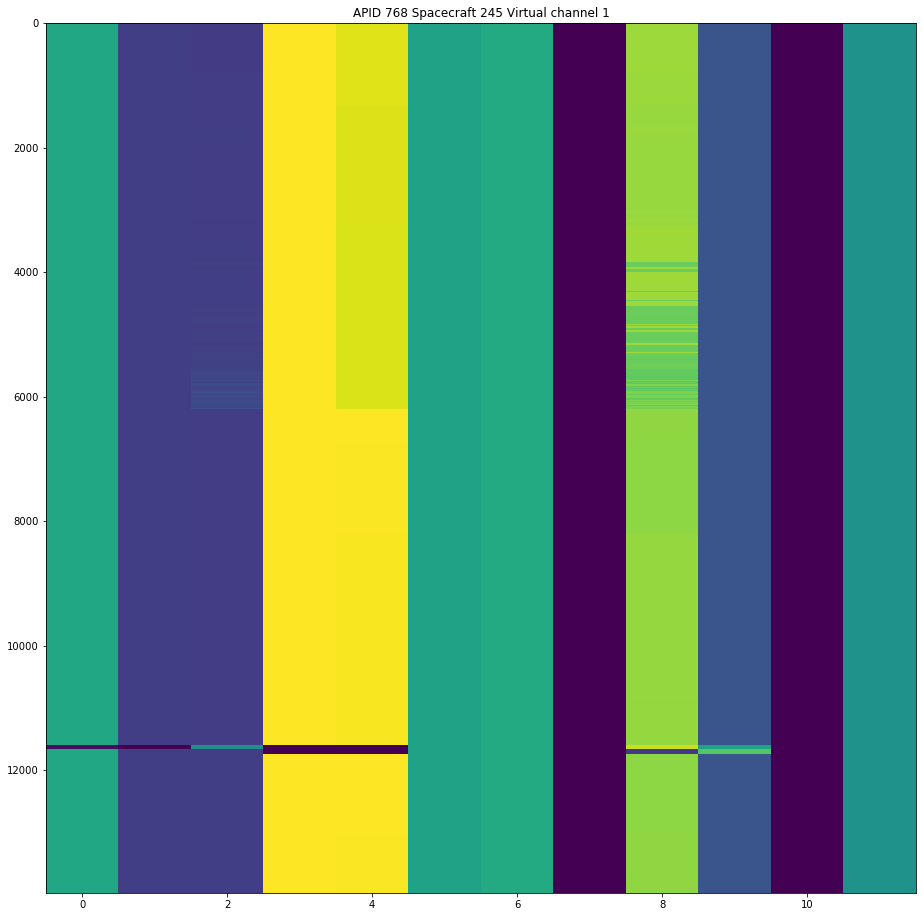

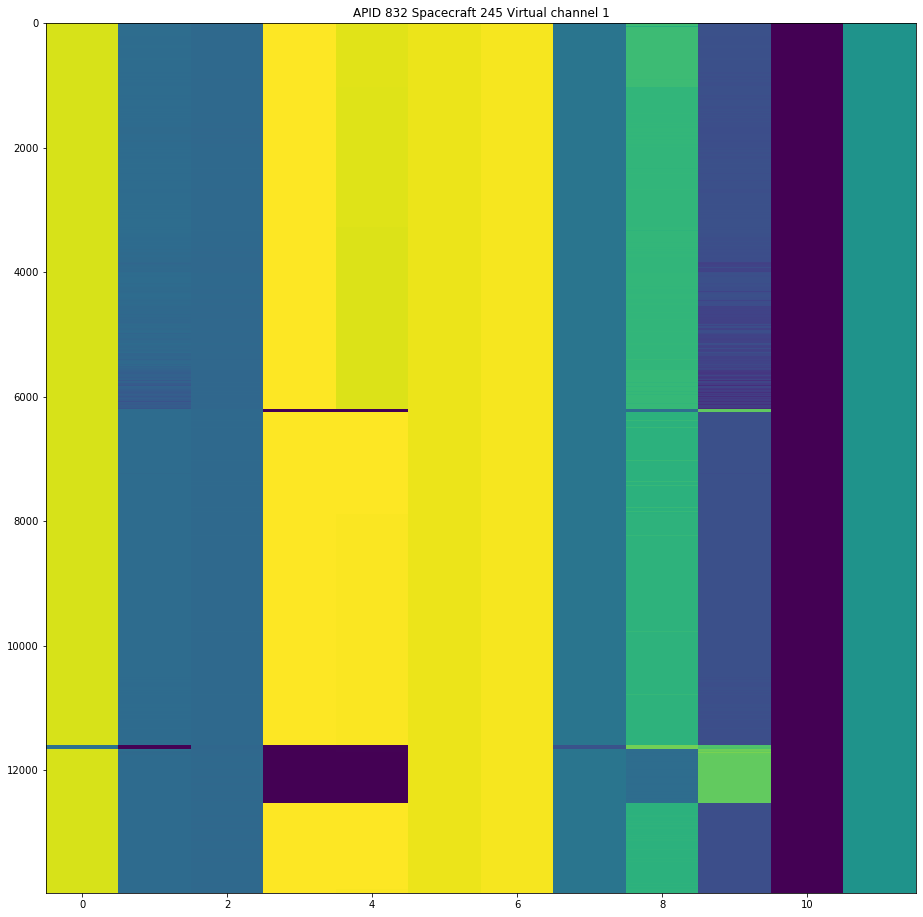

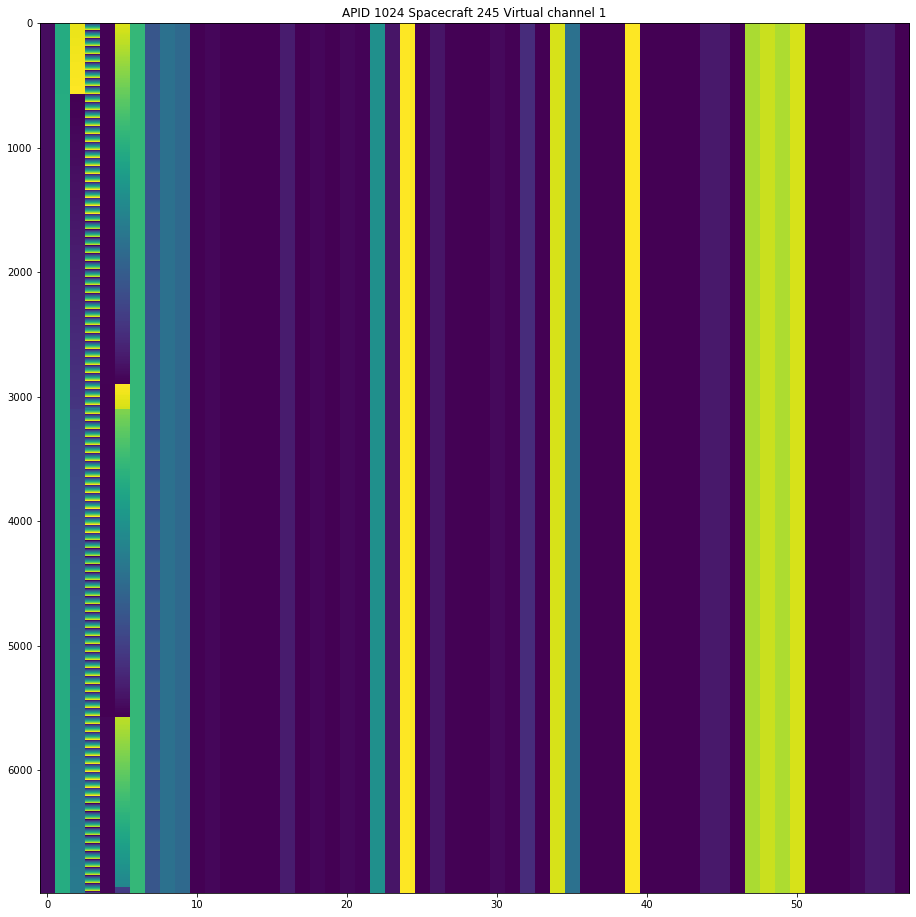

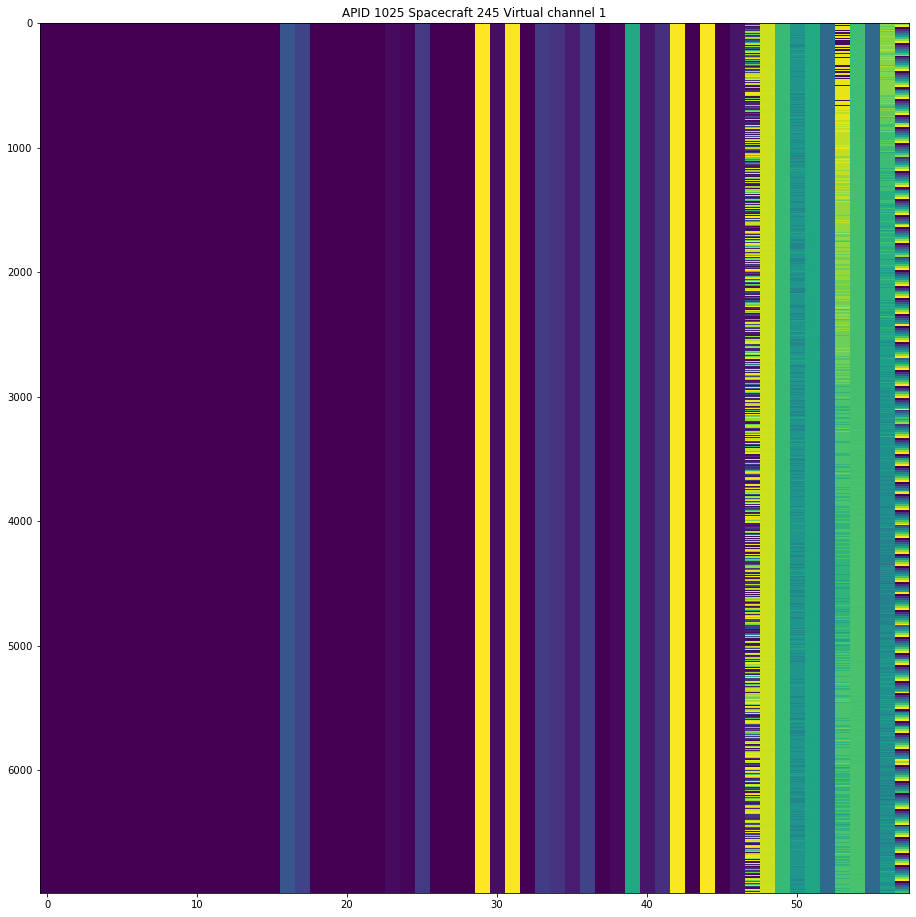

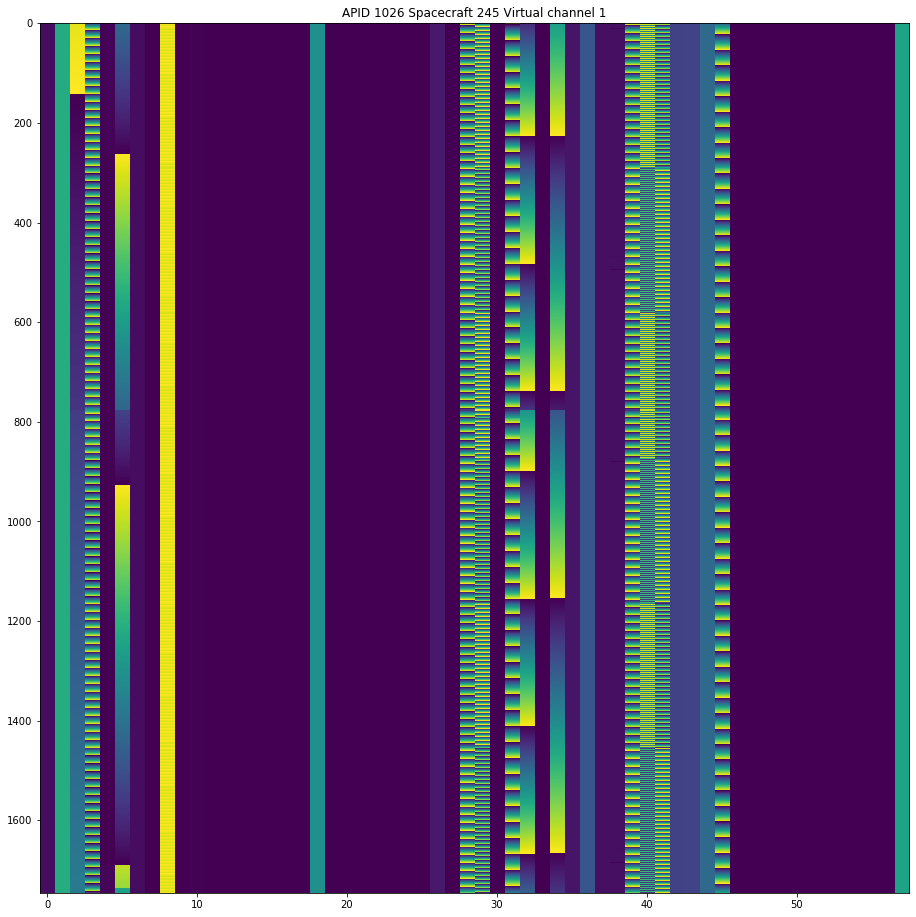

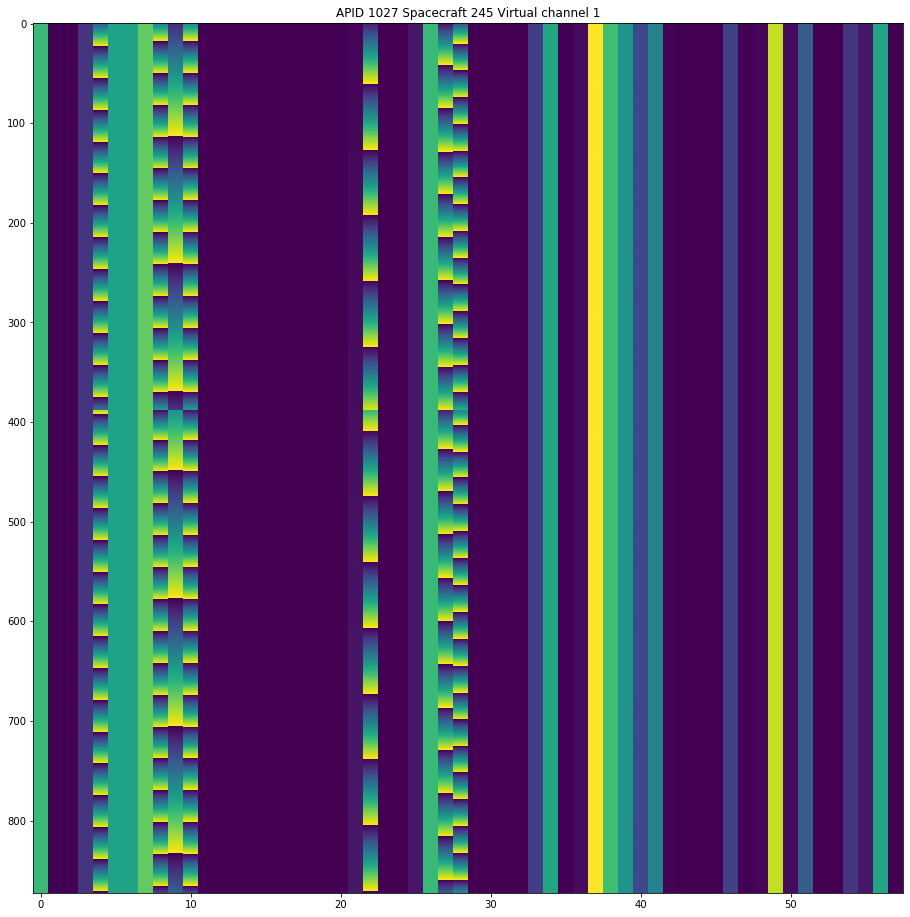

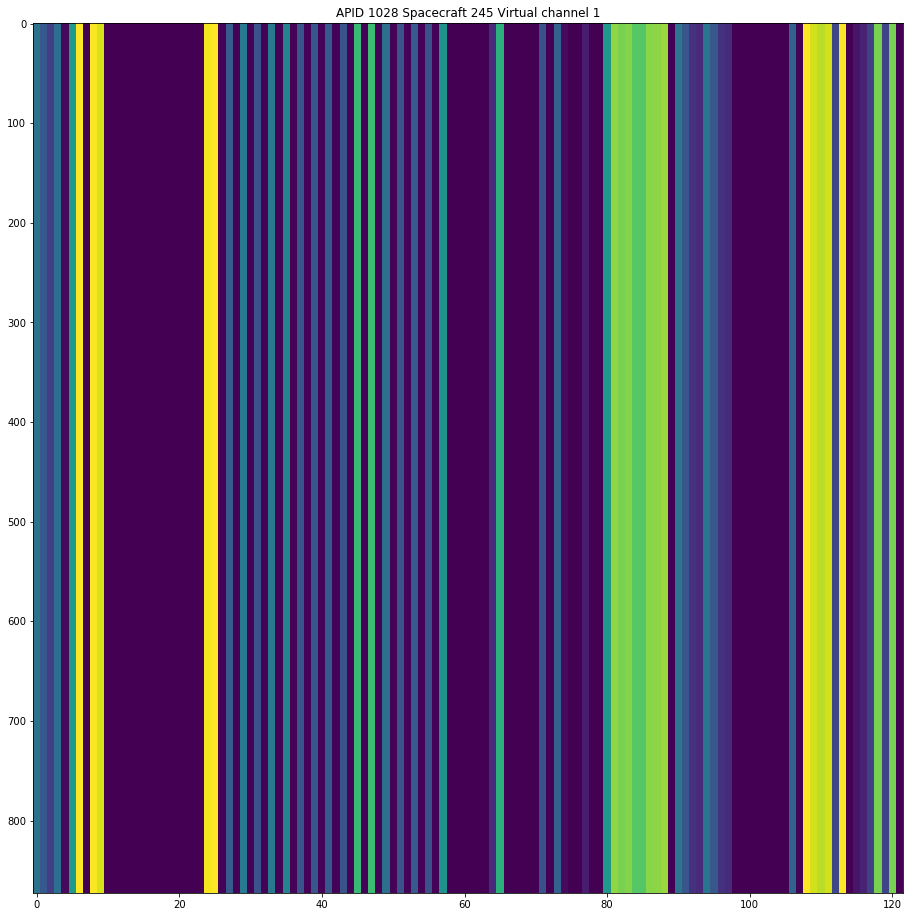

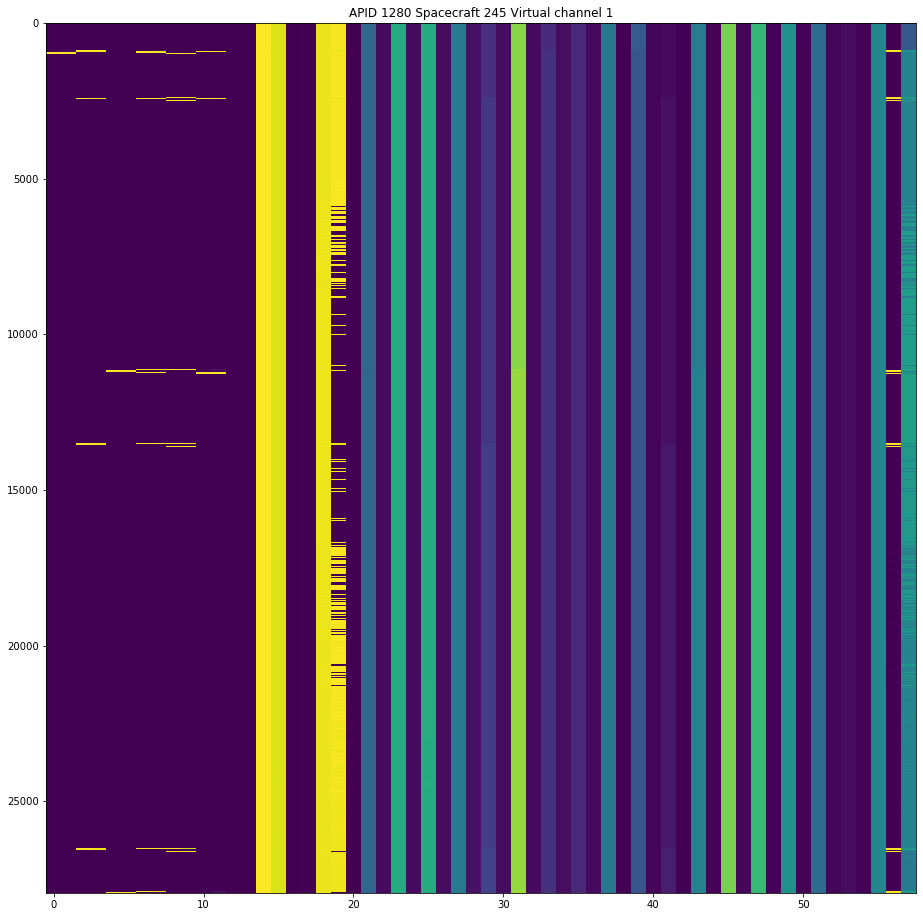

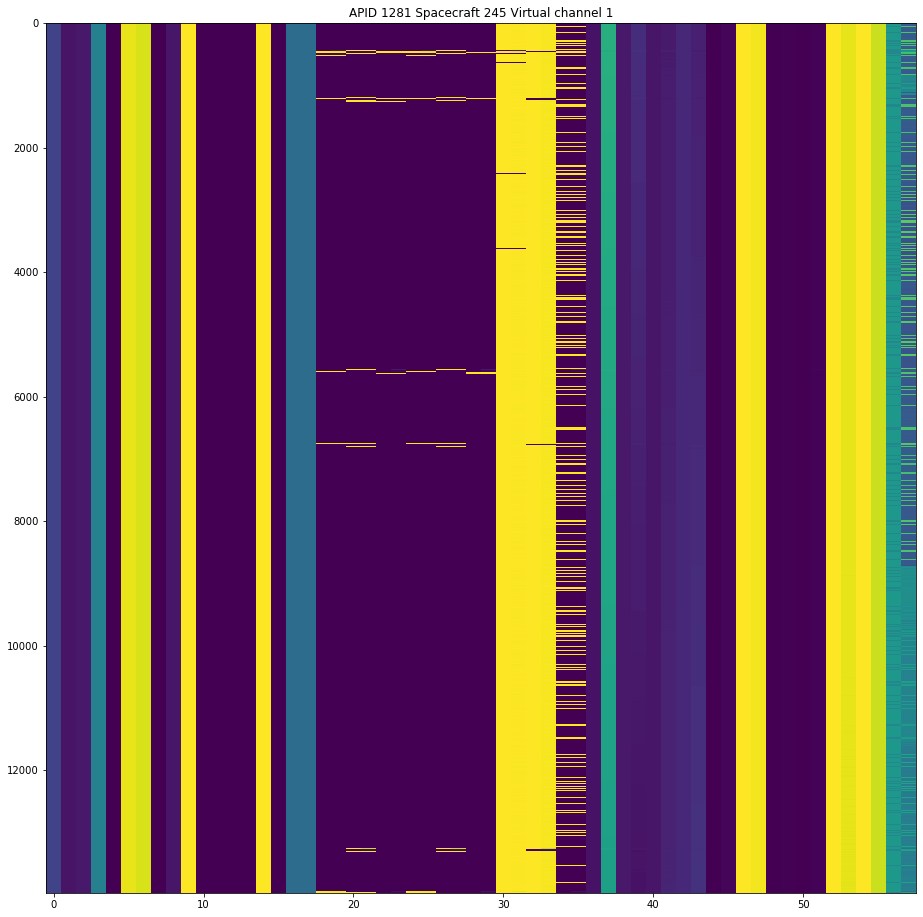

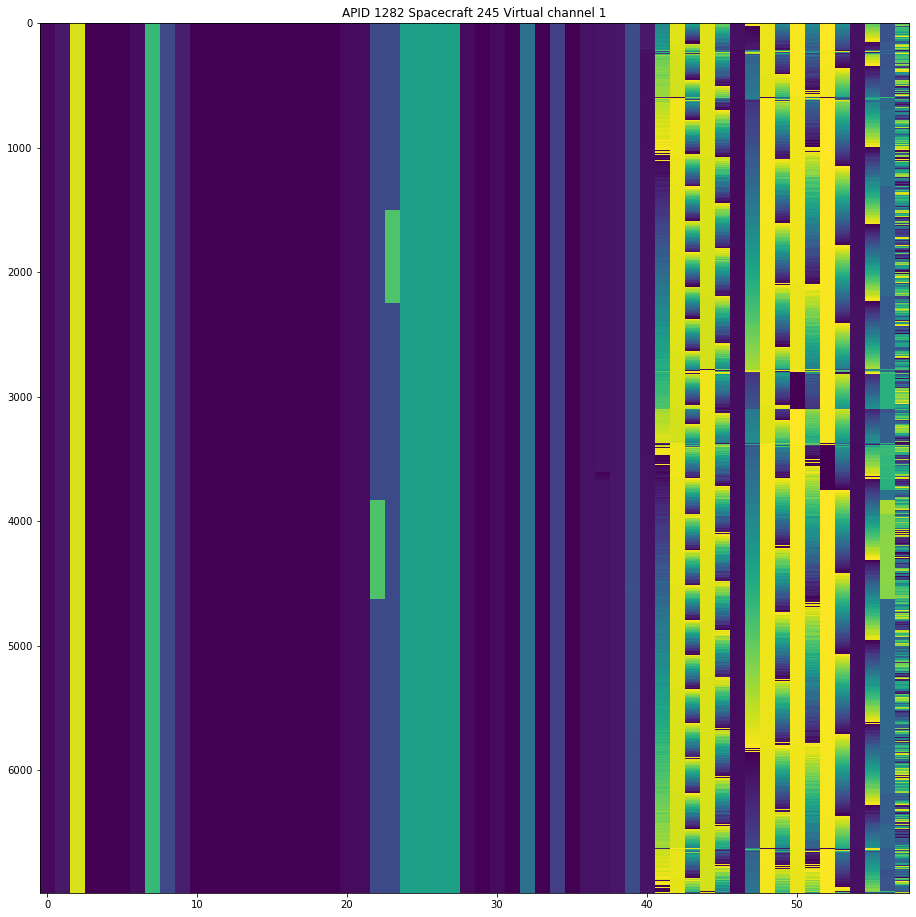

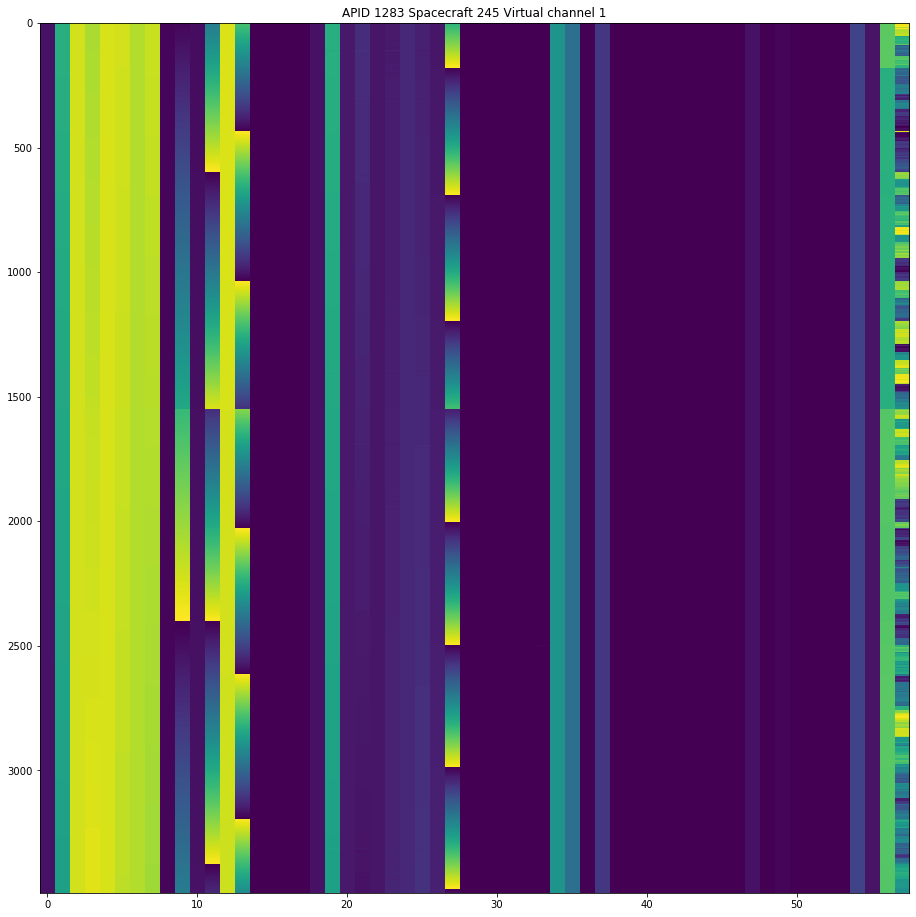

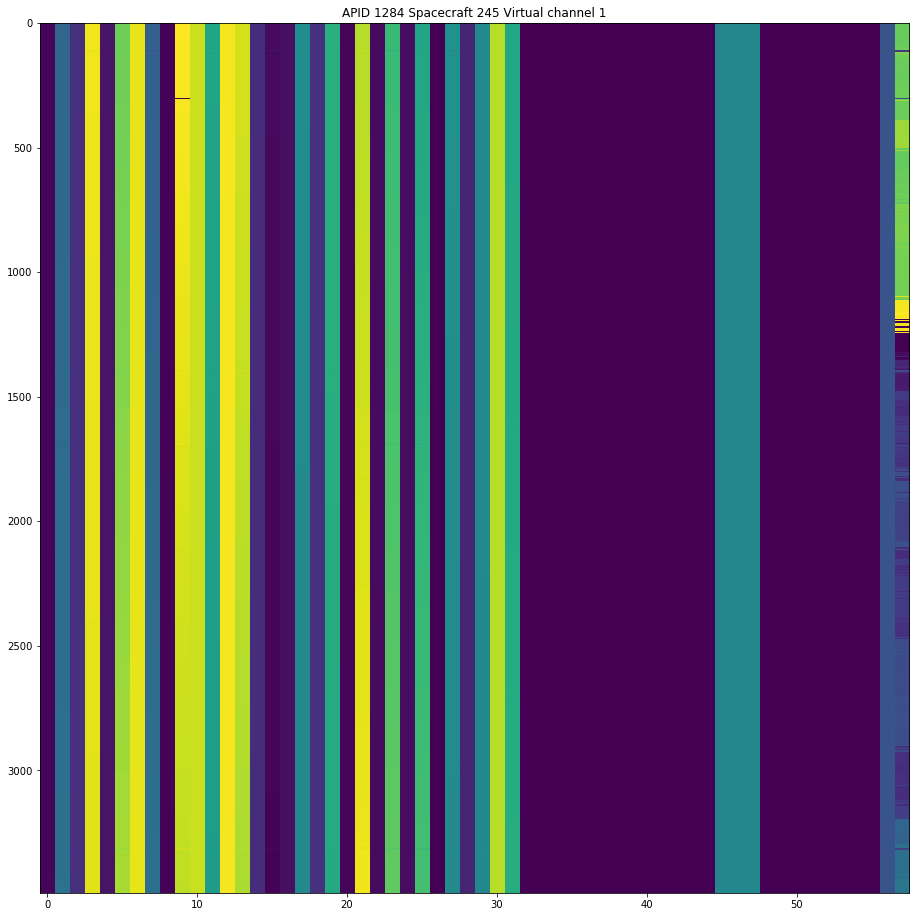

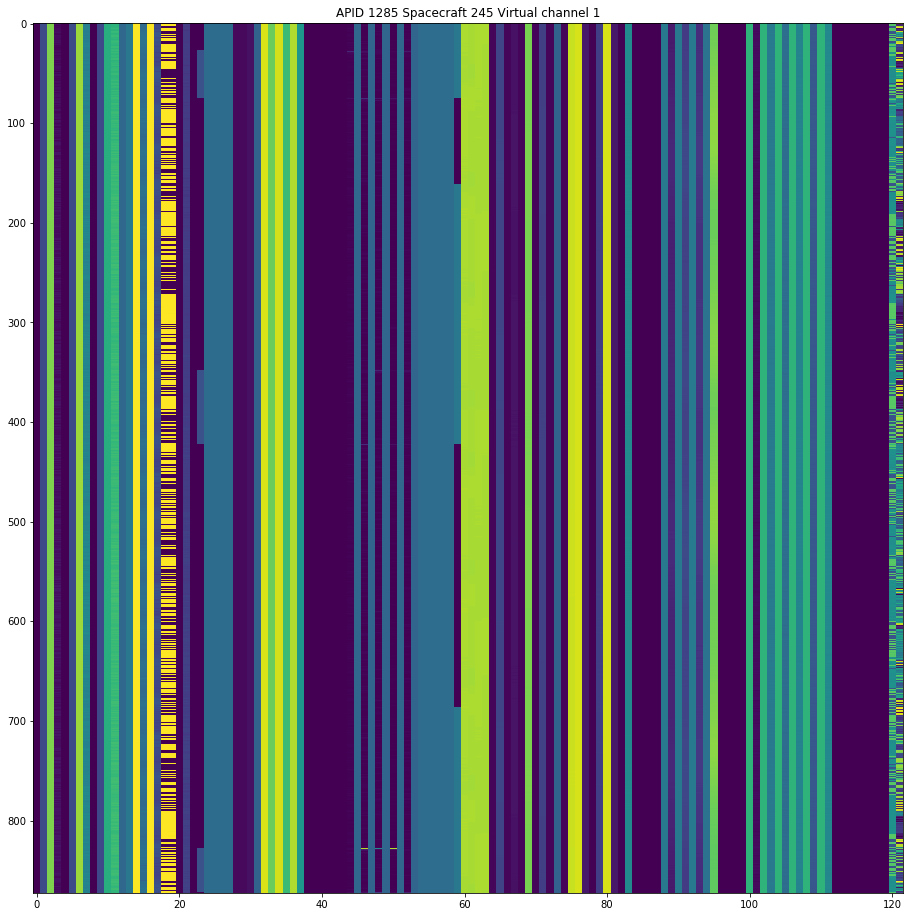

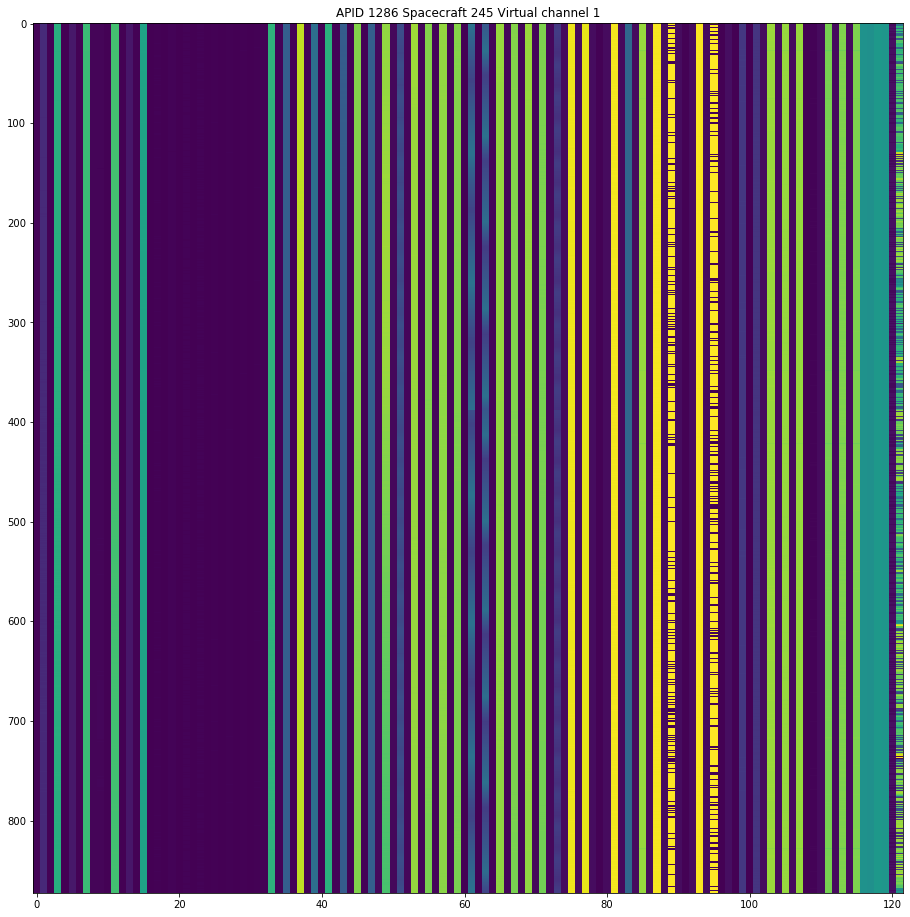

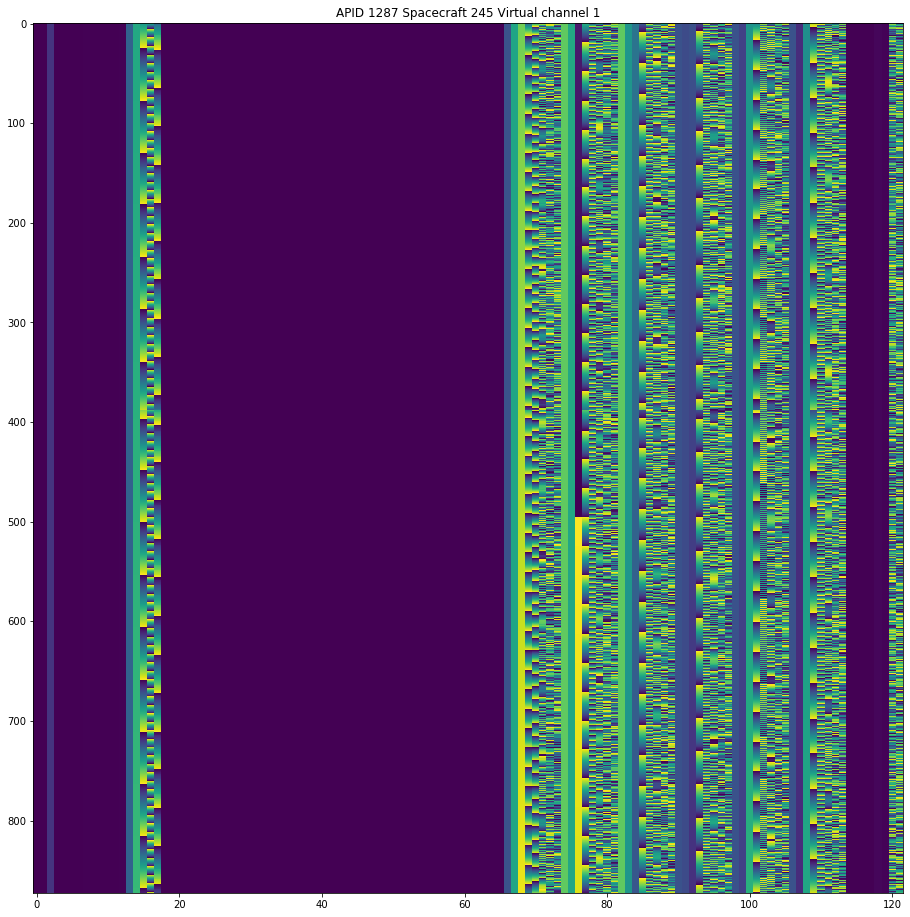

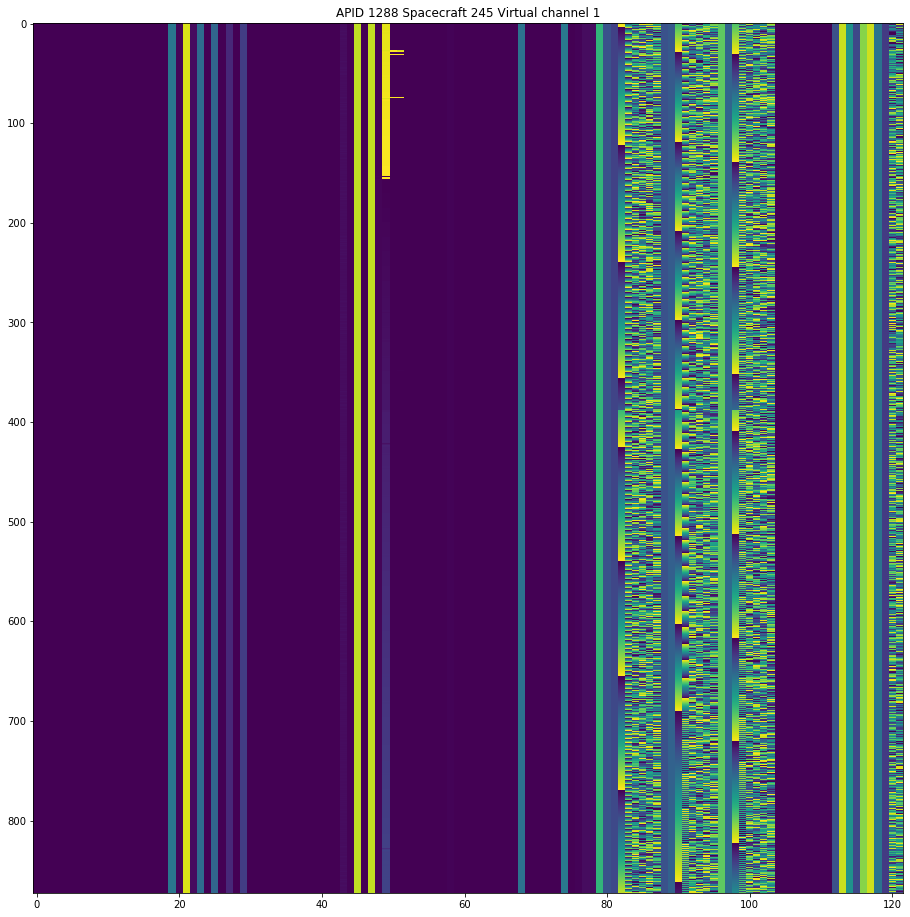

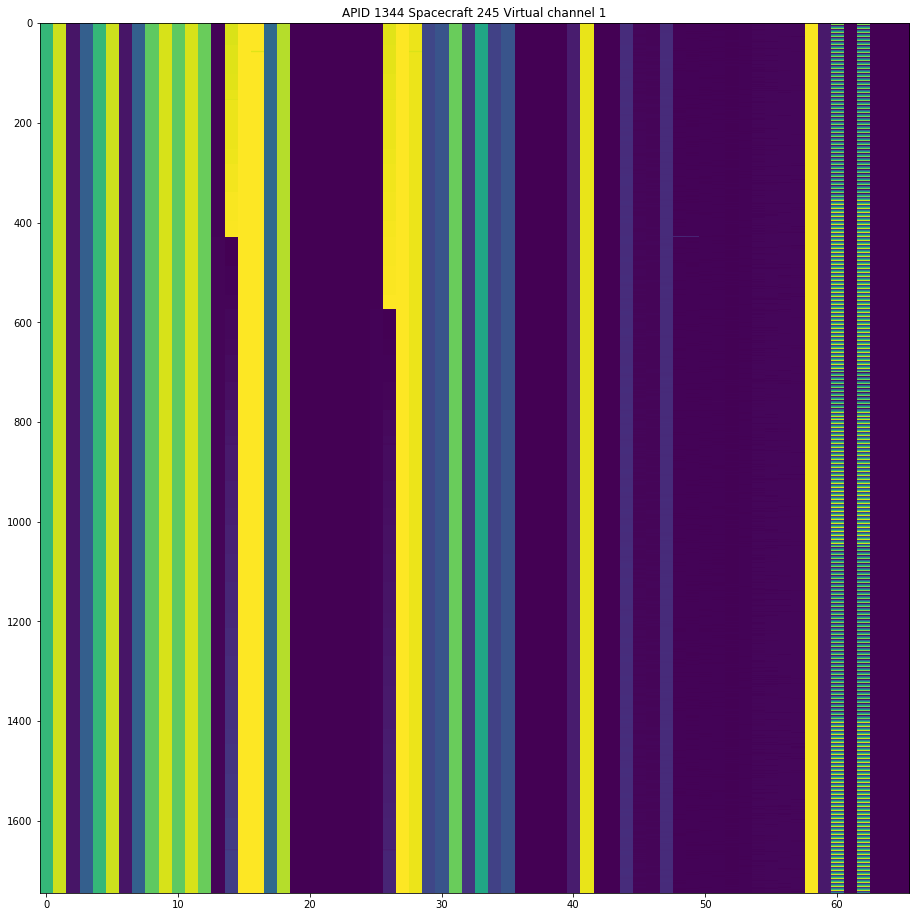

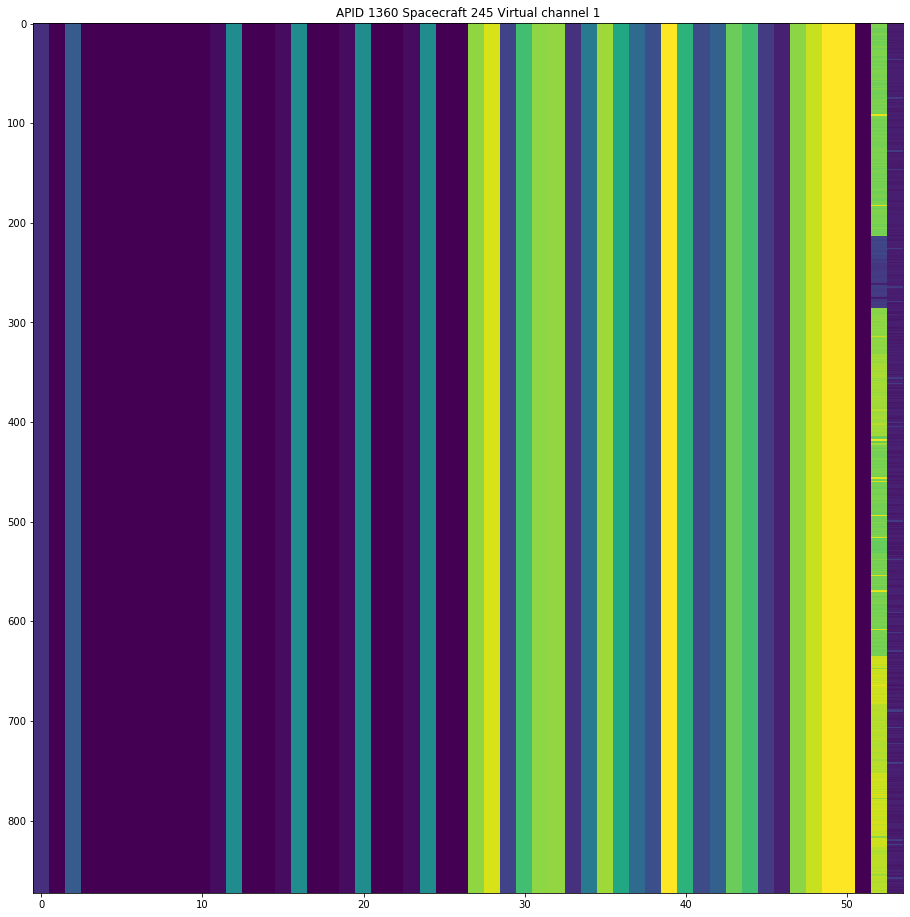

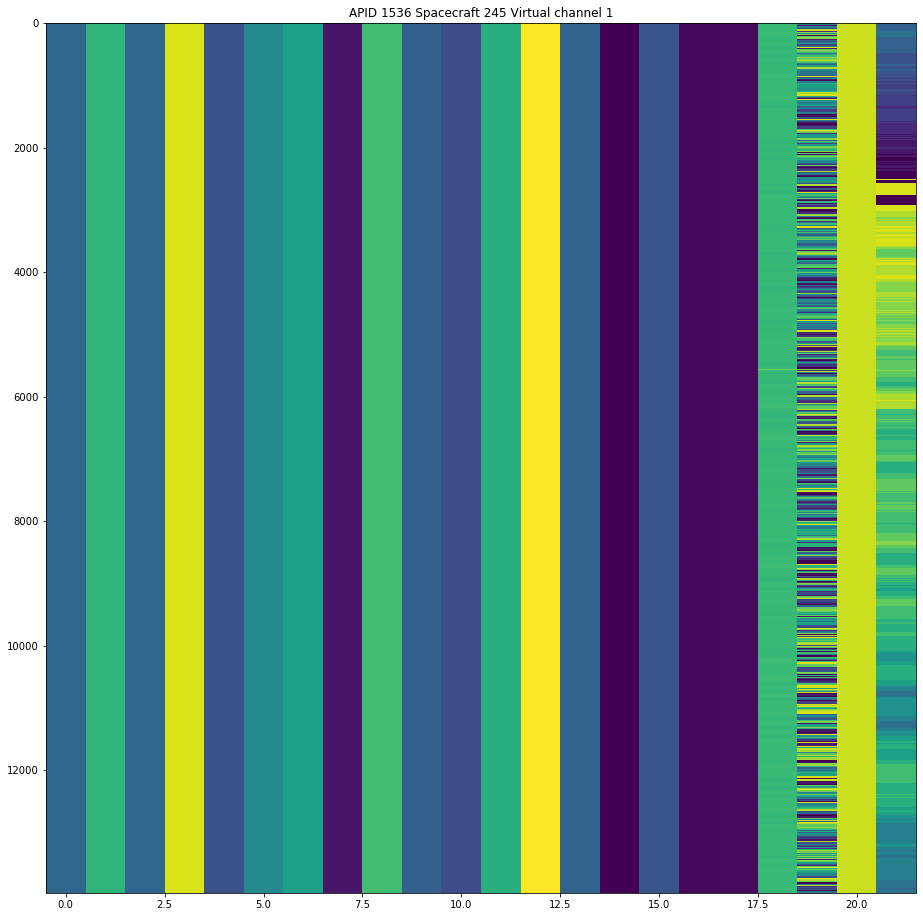

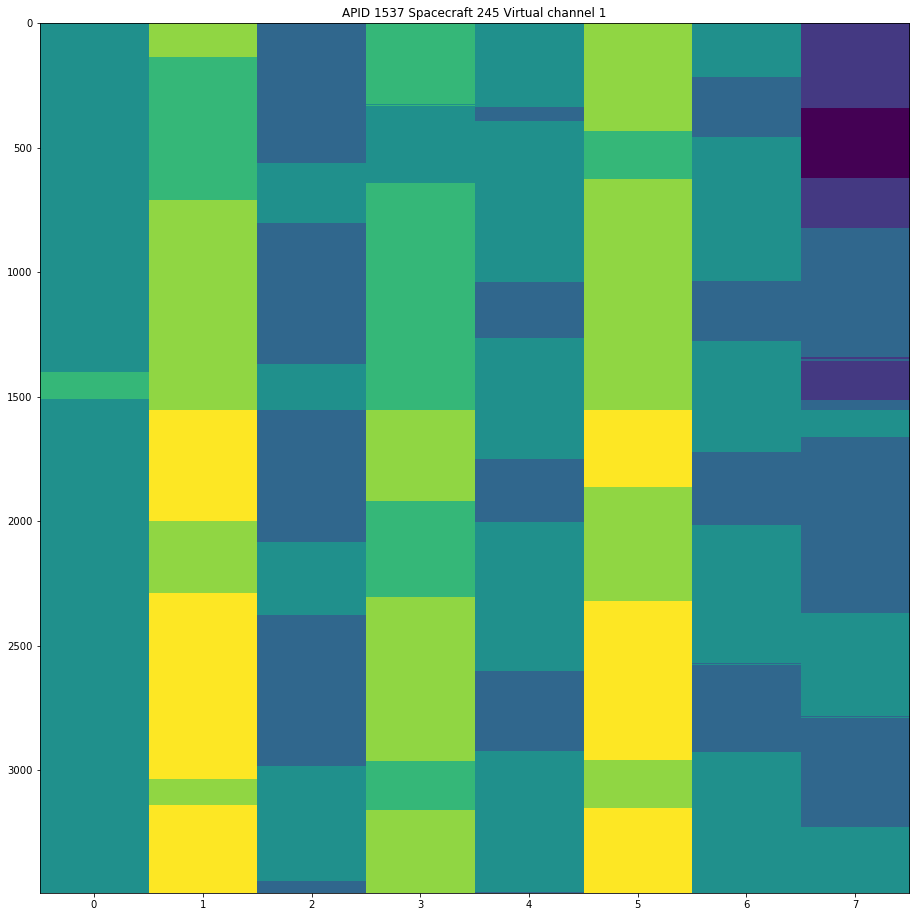

In [40]:
plot_apids(sc245_vc1_by_apid, 245, 1)

### APID 1280

In [41]:
channels = packets_asarray(sc245_vc1_by_apid[1280]).view('int16').byteswap()
timestamps = get_packet_timestamps(sc245_vc1_by_apid[1280])

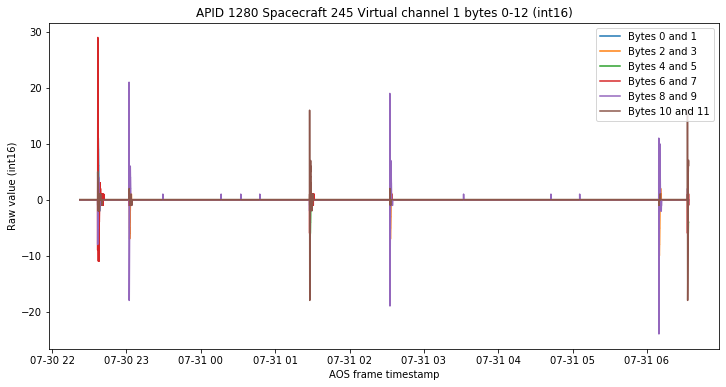

In [42]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps, channels[:,:6])
plt.title('APID 1280 Spacecraft 245 Virtual channel 1 bytes 0-12 (int16)')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (int16)')
plt.legend([f'Bytes {j} and {j+1}' for j in range(0,12,2)]);

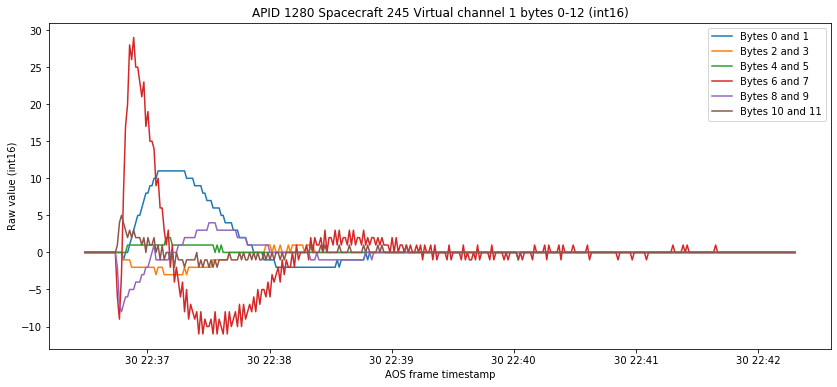

In [43]:
plt.figure(figsize = (14,6), facecolor = 'w')
sel = slice(850,1200)
plt.plot(timestamps[sel], channels[sel,:6])
plt.title('APID 1280 Spacecraft 245 Virtual channel 1 bytes 0-12 (int16)')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (int16)')
plt.legend([f'Bytes {j} and {j+1}' for j in range(0,12,2)]);

### APID 1281

In [44]:
channels = packets_asarray(sc245_vc1_by_apid[1281]).view('int16').byteswap()
timestamps = get_packet_timestamps(sc245_vc1_by_apid[1281])

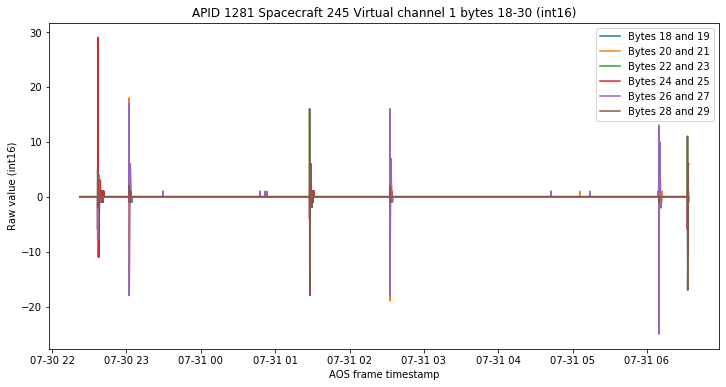

In [45]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps, channels[:,9:15])
plt.title('APID 1281 Spacecraft 245 Virtual channel 1 bytes 18-30 (int16)')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (int16)')
plt.legend([f'Bytes {j} and {j+1}' for j in range(9*2,15*2,2)]);

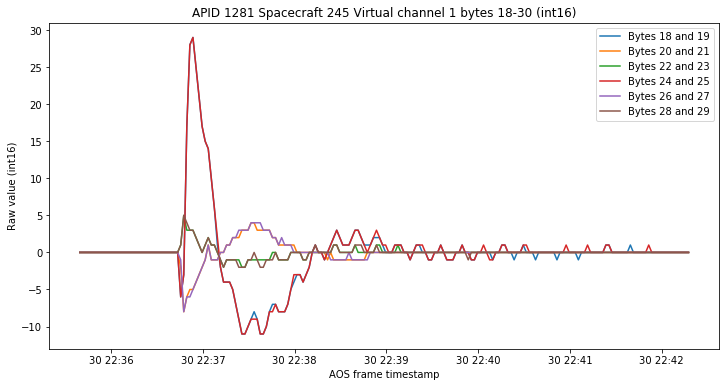

In [46]:
plt.figure(figsize = (12,6), facecolor = 'w')
sel = slice(400,600)
plt.plot(timestamps[sel], channels[sel,9:15])
plt.title('APID 1281 Spacecraft 245 Virtual channel 1 bytes 18-30 (int16)')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (int16)')
plt.legend([f'Bytes {j} and {j+1}' for j in range(9*2,15*2,2)]);

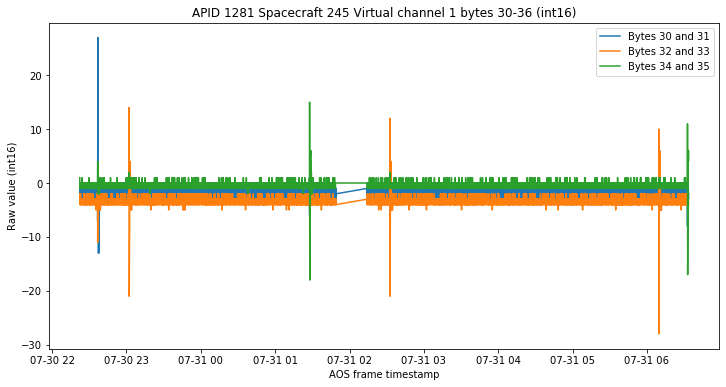

In [47]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps, channels[:,15:18])
plt.title('APID 1281 Spacecraft 245 Virtual channel 1 bytes 30-36 (int16)')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (int16)')
plt.legend([f'Bytes {j} and {j+1}' for j in range(2*15,18*2,2)]);

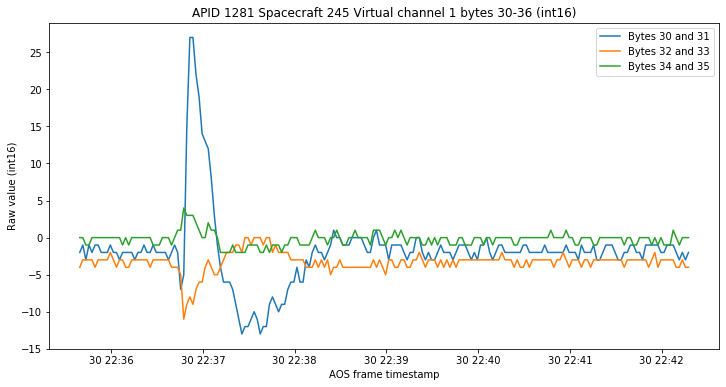

In [48]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps[sel], channels[sel,15:18])
plt.title('APID 1281 Spacecraft 245 Virtual channel 1 bytes 30-36 (int16)')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (int16)')
plt.legend([f'Bytes {j} and {j+1}' for j in range(2*15,18*2,2)]);

### APID 1288

In [49]:
channels = np.copy(packets_asarray(sc245_vc1_by_apid[1288])[:,80:][:,:3*8]).view('float64').byteswap()
timestamps = get_packet_timestamps(sc245_vc1_by_apid[1288])

# clean gap
channels[np.argmax(np.diff(timestamps)),:] = np.nan

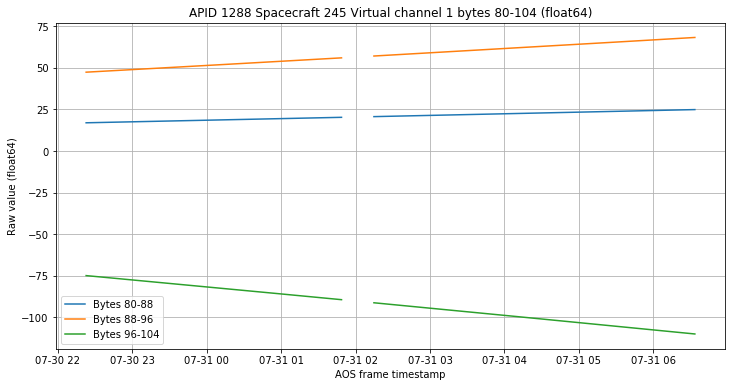

In [50]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps, channels)
plt.title('APID 1288 Spacecraft 245 Virtual channel 1 bytes 80-104 (float64)')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (float64)')
plt.legend([f'Bytes {j}-{j+8}' for j in range(80,104,8)])
plt.grid();

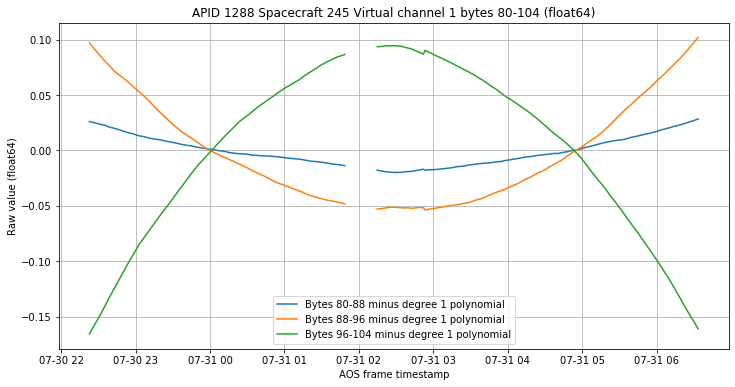

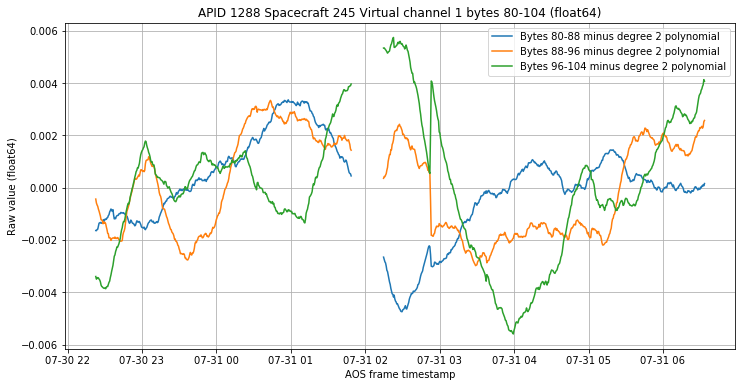

In [51]:
for deg in [1,2]:
    plt.figure(figsize = (12,6), facecolor = 'w')
    for j in range(channels.shape[1]):
        s = (timestamps - timestamps[0])/np.timedelta64(1,'s')
        sel = ~np.isnan(channels[:,j])
        p = np.polyfit(s[sel], channels[sel,j], deg)
        plt.plot(timestamps, channels[:,j] - np.polyval(p, s))
    plt.title('APID 1288 Spacecraft 245 Virtual channel 1 bytes 80-104 (float64)')
    plt.xlabel('AOS frame timestamp')
    plt.ylabel('Raw value (float64)')
    plt.legend([f'Bytes {j}-{j+8} minus degree {deg} polynomial' for j in range(80,104,8)])
    plt.grid();

### APIDs 2 and 3

In [52]:
channels2 = packets_asarray(sc245_vc1_by_apid[2])
timestamps2 = get_packet_timestamps(sc245_vc1_by_apid[2])
channels3 = packets_asarray(sc245_vc1_by_apid[2])
timestamps3 = get_packet_timestamps(sc245_vc1_by_apid[2])

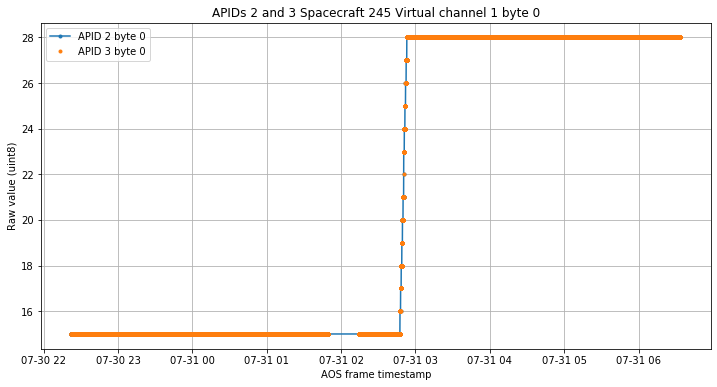

In [53]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps2, channels2[:,0], '.-', label = 'APID 2 byte 0')
plt.plot(timestamps3, channels3[:,0], '.', label = 'APID 3 byte 0')
plt.title('APIDs 2 and 3 Spacecraft 245 Virtual channel 1 byte 0')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (uint8)')
plt.legend()
plt.grid()

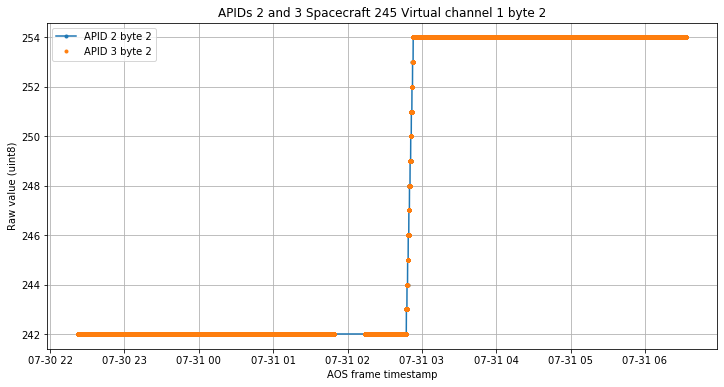

In [54]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps2, channels2[:,2], '.-', label = 'APID 2 byte 2')
plt.plot(timestamps3, channels3[:,2], '.', label = 'APID 3 byte 2')
plt.title('APIDs 2 and 3 Spacecraft 245 Virtual channel 1 byte 2')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (uint8)')
plt.legend()
plt.grid()

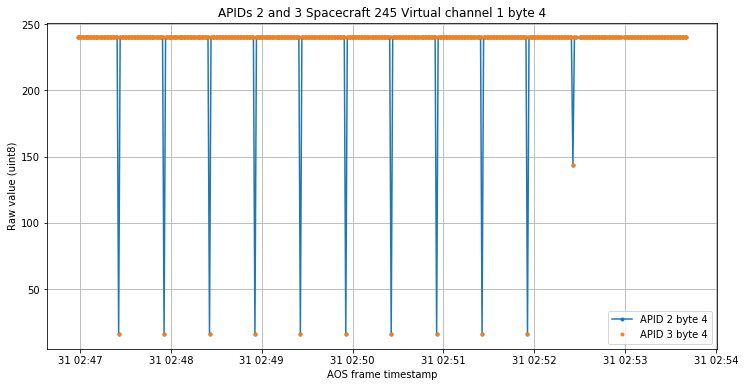

In [55]:
plt.figure(figsize = (12,6), facecolor = 'w')
sel = slice(14350, 14350+400)
plt.plot(timestamps2[sel], channels2[sel,4], '.-', label = 'APID 2 byte 4')
plt.plot(timestamps3[sel], channels3[sel,4], '.', label = 'APID 3 byte 4')
plt.title('APIDs 2 and 3 Spacecraft 245 Virtual channel 1 byte 4')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (uint8)')
plt.legend()
plt.grid()

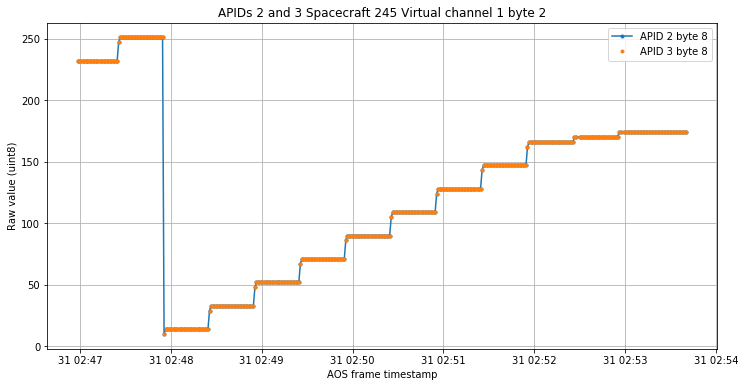

In [56]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps2[sel], channels2[sel,8], '.-', label = 'APID 2 byte 8')
plt.plot(timestamps3[sel], channels3[sel,8], '.', label = 'APID 3 byte 8')
plt.title('APIDs 2 and 3 Spacecraft 245 Virtual channel 1 byte 2')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (uint8)')
plt.legend()
plt.grid()

### APID 454

In [57]:
channels = packets_asarray(sc245_vc1_by_apid[454])
timestamps = get_packet_timestamps(sc245_vc1_by_apid[454])

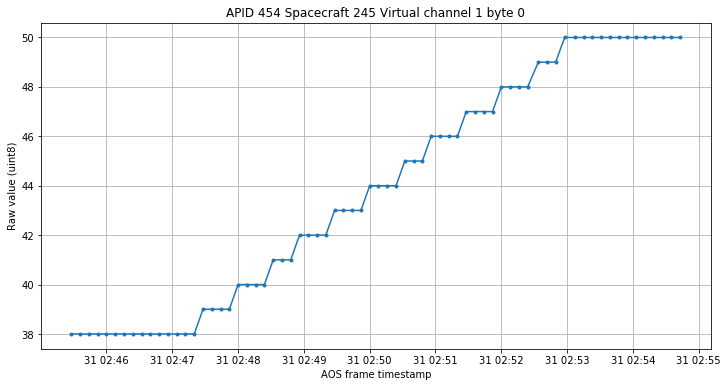

In [58]:
plt.figure(figsize = (12,6), facecolor = 'w')
sel = slice(1780,1850)
plt.plot(timestamps[sel], channels[sel,0], '.-')
plt.title('APID 454 Spacecraft 245 Virtual channel 1 byte 0')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (uint8)')
plt.grid()

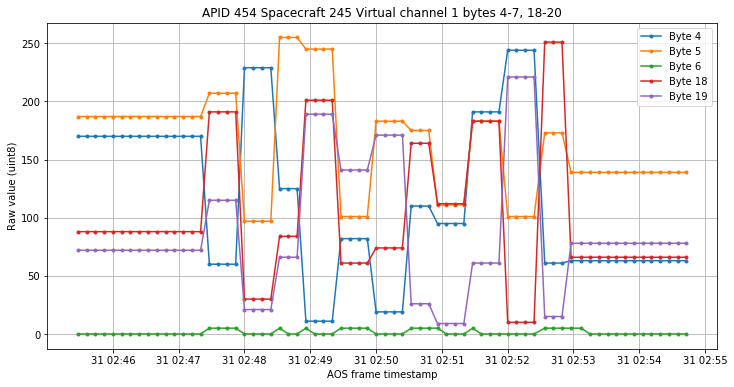

In [59]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps[sel], channels[sel,4:7], '.-')
plt.plot(timestamps[sel], channels[sel,18:20], '.-')
plt.title('APID 454 Spacecraft 245 Virtual channel 1 bytes 4-7, 18-20')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (uint8)')
plt.legend([f'Byte {j}' for j in list(range(4,7)) + list(range(18,20))])
plt.grid()

### APID 462

In [60]:
channels = packets_asarray(sc245_vc1_by_apid[462]).view('int16').byteswap()
timestamps = get_packet_timestamps(sc245_vc1_by_apid[462])

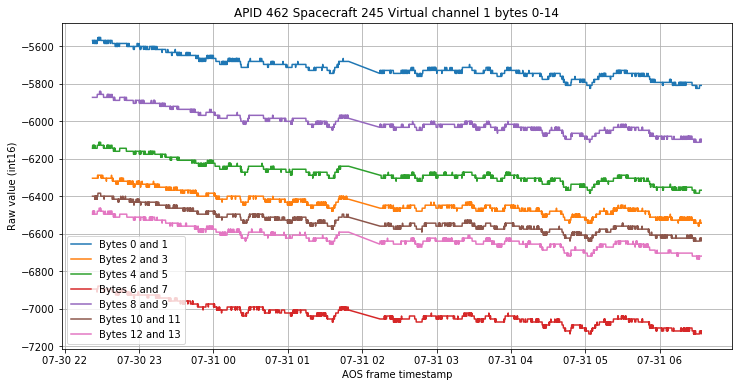

In [61]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps, channels[:,:7])
plt.title('APID 462 Spacecraft 245 Virtual channel 1 bytes 0-14')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (int16)')
plt.legend([f'Bytes {j} and {j+1}' for j in range(0,14,2)])
plt.grid()

### APID 1536

In [62]:
channels = packets_asarray(sc245_vc1_by_apid[1536]).view('int16').byteswap()
timestamps = get_packet_timestamps(sc245_vc1_by_apid[1536])

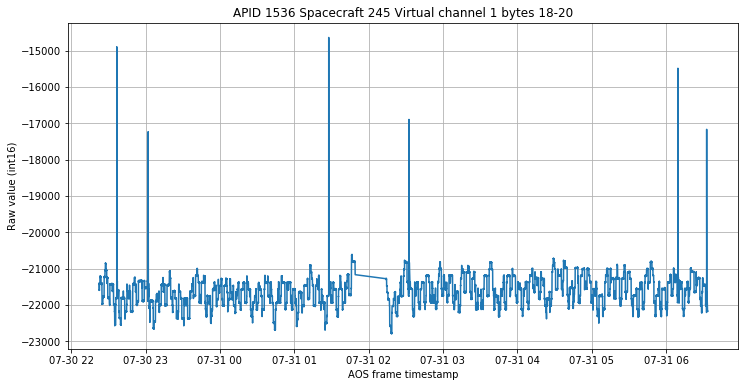

In [63]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps, channels[:,9])
plt.title('APID 1536 Spacecraft 245 Virtual channel 1 bytes 18-20')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (int16)')
plt.grid()

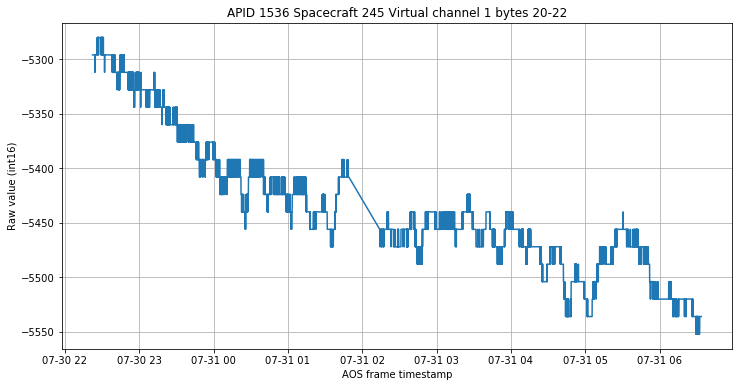

In [64]:
plt.figure(figsize = (12,6), facecolor = 'w')
plt.plot(timestamps, channels[:,10])
plt.title('APID 1536 Spacecraft 245 Virtual channel 1 bytes 20-22')
plt.xlabel('AOS frame timestamp')
plt.ylabel('Raw value (int16)')
plt.grid()